# Exploratory Data Analysis of World Development Indicators
---

 <a id='Executive'></a>

## Executive Summary

Initially we have found that:
- Countries change income groups from year to year
- Higher income groups are growing while lower income groups are shrinking.
- Features are showing a growth in access and standards of living among all income groups.
- This all leads to the world becoming more developed.


The major indicator that determines income group is GNI per capita.  Countries fall into certain groups based off of this indicator.  This indicator is also correlated to many world development indicators and is worth a deep dive.

In analyzing our data, we were able to separate our indicators into various categories:
- Economic Policy and Debt
- Education and Gender Issues
- Access to Advanced Communications
- Environment, Resources and Population
- Social Protection and Labor
- Health

-----

**Economic Policy and Debt**

We have found that GNI and GDP both deal with the economic outlook of a country.  Also, external balance of goods and services are heavily skewed to countries that consume and countries that produce.  Many center their entire economic policies around their production or consumption of resources.  Annual GDP growth is larger among lower income countries than higher income countries.  On average, low income countries outpace high income countries in annual GDP growth by 3.1% annually.  

**Education and Gender Issues**

The average required amount of years for schooling among all income groups is between 8 and 10 years with little correlation to GNI per capita.  The average proportion of seats held by women in national parliaments ranges between 21.8% and 17.5% for all income groups which leads to very little correlation to GNI per capita.

**Access to Advanced Communications**

Internet usage varies exponentially among income groups but with the prevalence of the internet, usage appears considerably low.  This is likely due to differences in age and population location (rural vs. urban).  Over time, all income groups have seen a rise in their populations using the internet, which is very much correlated to GNI per capita.  Mobile cellular subscriptions increase with the income level of a country.  Also, all income groups have seen a large increase in mobile cellular subscriptions rates ranging between a 50 and 60 rate increase per group.

**Environment, Resources and Population**

Access to electricity is extremely prevalent among high and upper middle income countries and starts to dip as among lower middle and low income countries.  Access to clean fuels and technologies for cooking relates to access to electricity as the visual depictions of the data look identical.  Total natural resources rents see a few countries, regardless of income group, produce most of the natural resources involved in oil, natural gases, coal, minerals and forests.  There is a significant difference in means of urban population to total population from income group to income group.  This is likely due to the differences in workforce which can be seen in the social protection and labor section.  Urban population is directly negatively correlated to rural population.

**Social Protection and Labor**

Labor force participation is roughly the same for high income countries and low income countries at 71%, and is on the rise.  It is possible that the need to work in low income countries to survive and the need to work in high income countries to maintain lifestyle is why they are just about even.  Contributing family workers are those who work with family members who operate their own businesses.  Low income countries high the highest percentage of contributing family workers.  This is likely due to the need to work as a community within a household in order to survive as income categories lessen.  For example, a family in a third world country may own and operate a small grocery store from within their house, or parents employing their children in a restaurant.  The ratio of dependents (under 15 and over 64) to the working population grows as income groups become lower.  This is likely due to the increased rate of fertility for women in lower income countries coupled with the possibility that people over 64 years of age are more likely to have retirement funds in higher income countries.

Employment in services is extremely high among high income countries and dips in lower income countries.  This is likely because high income countries engage in more service related jobs, while low income countries engage in more agriculture related jobs.  While over half of the total workforce in low income countries work in agriculture, not even 1 in 20 of the total workforce do in high income countries.  The difference in means is over 56%.  Employment in industry, among all income groups, have seen a drop.  This is probably due to the increase of automation in manufacturing, quarrying, mining and some utility jobs.

**Health**

Access to basic drinking water is major in determining income groups.  Although, on average, life expectancy is much higher among high income countries, the minimum life expectancy among most income groups is on the rise per year with low income countries leading the extension averaging a 3 year increase in life expectancy.

-----

As we begin to analyze these indicators, we start to see many patterns as they relate to income groups.  We will now go through the report, extensively, in order to deep dive into what the data is telling us.

<a id='Table of Contents'></a>

<a id='Table of Contents'></a>

-----
## Table of Contents 


#### <a href='#Executive'>Executive Summary</a>

#### <a href='#Intro'>Introduction</a>

----
#### <a href='#Import'>Import Tools, Read in and Separate Data, Define Functions</a>


- <a href='#Functions'>Defining Functions</a>

----
#### <a href='#Year to Year Change in Income Groups'>Year to Year Change in Income Groups</a>

#### <a href='#Income Group Overview'>Income Group Overview</a>

#### <a href='#Economic Policy and Debt'>Economic Policy and Debt</a>

- <a href='#GNI per capita'>GNI per capita</a>

- <a href='#GDP per capita, PPP'>GDP per capita, PPP</a>

- <a href='#GDP growth (annual %)'>GDP growth (annual %)</a>

- <a href='#External balance on goods and services (% of GDP)'>External balance on goods and services (% of GDP)</a>

#### <a href='#Education and Gender Issues'>Education and Gender Issues</a>

- <a href='#duration of compulsory education'>duration of compulsory education</a>

- <a href='#proportion of seats held by women in national parliaments'>proportion of seats held by women in national parliaments</a>

#### <a href='#Access to Advanced Communications'>Access to Advanced Communications</a>

- <a href='#individuals using the internet'>individuals using the internet</a>

- <a href='#mobile cellular subscriptions'>mobile cellular subscriptions</a>

#### <a href='#Environment, Resources and Population'>Environment, Resources and Population</a>

- <a href='#access to electricity'>access to electricity</a>

- <a href='#access to clean technology and fuels for cooking'>access to clean technology and fuels for cooking</a>

- <a href='#total natural resources rents'>total natural resources rents</a>

- <a href='#urban and rural population'>urban and rural population</a>

#### <a href='#Social Protection and Labor'>Social Protection and Labor</a>

- <a href='#labor force participation'>labor force participation</a>

- <a href='#contributing family workers'>contributing family workers</a>

- <a href='#dependents of the workforce'>dependents of the workforce</a>

- <a href='#employment in agriculture'>employment in agriculture</a>

- <a href='#employment in industry'>employment in industry</a>

- <a href='#employment in service'>employment in service</a>

#### <a href='#Health'>Health</a>

- <a href='#basic drinking water'>basic drinking water</a>

- <a href='#fertility rates'>fertility rates</a>

- <a href='#infant mortality rates'>infant mortality rates</a>

- <a href='#life expectancy'>life expectancy</a>

#### <a href='#Diving Deeper with Indicator Correlations'>Diving Deeper with Indicator Correlations</a>

#### <a href='#End'>Conclusion</a>

-----  <a id='Intro'></a>

## Introduction

There are a plethora of factors that determine how developed a country is in the world. Typically, countries are considered to be developed if they:

- Are highly industrialized.
- Have a large female workforce and women in high ranking positions.
- Use a disproportionate amount of the world’s resources.
- Have stable birth and death rates.
- Have higher levels of debt, usually for production.
- Have a high Gross Domestic Production (GDP) per Capita
- And much more.

Outside of the developed category, there are developing countries that range from being highly developed to underdeveloped. For example; although it is the world’s second largest economy, China falls into a developing country category because of the disparity in it’s wealth, quality of life, and GDP per capita. Argentina is also considered a developing country because of its political disarray, economic uncertainty and erosion of quality of life despite ranking higher in vast majorities of metrics as compared to other countries.


### Problem Statement:
Development within a country will always be a continuous journey because of ever changing conditions. In the pursuit of maintaining and upgrading these levels, we want to determine what stage of development a country is in and help it acquire the tools necessary to continue building itself.

In this project, specifically, we want to look at the income group countries fall into and their development factors in order to create a multiclass classification prediction model.

<a href='#Table of Contents'>Table of Contents</a>

----- <a id='Import'></a>
## Import Tools, Read in and Separate Data, Define Functions 


In order to easily navigate through this report, we will import our libraries and read in all of are data and separate it in order to have access to:
- World Development Indicators
- Income Group Criteria
- Filtered Income Groups
- Correlated Indicators
- GNI Statistics

We will also define functions in order to show:
- Cumulative Distributions
- Income Group Changes Over Time
- Definition of Each Indicator
- Comparisons Between Income Groups
- Statistical Analysis Between Income Groups
- Indicator Changes Over Time Between Income Groups
- Comparisons Between Indicators and Income Group Criteria

This will allow us to navigate through our analysis without long pieces of code separating each piece of information that is presented before us.

<a href='#Table of Contents'>Table of Contents</a>

In [1]:
# Import tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# For anova tukey analysis
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
%matplotlib inline

In [2]:
# Read in data
wdi = pd.read_csv('WDI_csv/wrangled/wdi.csv')
wdi_pivot = pd.read_csv('WDI_csv/wrangled/wdi_pivot.csv')
wdi_pivot = wdi_pivot.sort_values(['country', 'year', 'income_group'])

# Forward fill 2015 values to missing 2016 values for one feature for line plot value label #-#
wdi_pivot.iloc[:,230] = wdi_pivot.iloc[:,230].fillna(method='ffill')

# Expected criteria for income group categories
income_group_criteria = pd.concat(
    [
    pd.read_excel('WDI_csv/OGHIST1.xlsx').iloc[5:9,0],
    pd.read_excel('WDI_csv/OGHIST1.xlsx').iloc[5:9,19:-1]
    ], 
    axis=1).rename(
    columns={
        'World Bank Analytical Classifications':'GNI per capita in US$ (Atlas methodology)',
        'Unnamed: 19': 2005, 
        'Unnamed: 20': 2006, 
        'Unnamed: 21': 2007, 
        'Unnamed: 22': 2008, 
        'Unnamed: 23': 2009, 
        'Unnamed: 24': 2010, 
        'Unnamed: 25': 2011, 
        'Unnamed: 26': 2012, 
        'Unnamed: 27': 2013, 
        'Unnamed: 28': 2014, 
        'Unnamed: 29': 2015, 
        'Unnamed: 30': 2016}
).set_index('GNI per capita in US$ (Atlas methodology)')
income_group_criteria = pd.concat([
    income_group_criteria.iloc[0]
    .str.replace('<= ','')
    .str.replace(',','')
    .astype(int),
    income_group_criteria.iloc[1]
    .str.replace(',','')
    .str.split('-', expand=True)
    .astype(int)
    .rename(columns={0:'Lower middle income min (LM)'})
    .rename(columns={1:'Lower middle income max (LM)'}),
    income_group_criteria.iloc[2]
    .str.replace(',','')
    .str.split('-', expand=True)
    .astype(int)
    .rename(columns={0:'Upper middle income  min (UM)'})
    .rename(columns={1:'Upper middle income  max (UM)'}),
    income_group_criteria.iloc[3]
    .str.replace('> ','')
    .str.replace(',','').astype(int)], axis=1).rename(columns={'High income (H)':'High income min (H)'})
income_group_criteria = income_group_criteria.rename(columns={'Low income (L)':'Low income max (L)'})

# Filter data by income group
high = wdi_pivot[wdi_pivot.income_group == 'High income']
upper_middle = wdi_pivot[wdi_pivot.income_group == 'Upper middle income']
lower_middle = wdi_pivot[wdi_pivot.income_group == 'Lower middle income']
low = wdi_pivot[wdi_pivot.income_group == 'Low income']

income_groups = [high, upper_middle, lower_middle, low]

# Indicator correlations
wdi_corr = wdi_pivot[[
    'Proportion of seats held by women in national parliaments (%)',
    'Compulsory education, duration (years)',
    'Individuals using the Internet (% of population)',
    'Mobile cellular subscriptions (per 100 people)',
    'Access to clean fuels and technologies for cooking (% of population)',
    'Access to electricity (% of population)',
    'Total natural resources rents (% of GDP)',
    'Rural population (% of total population)',
    'Urban population (% of total)',
    'Employment in agriculture (% of total employment) (modeled ILO estimate)',
    'Employment in industry (% of total employment) (modeled ILO estimate)',
    'Employment in services (% of total employment) (modeled ILO estimate)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'Commercial service exports (current US$)',
    'Commercial service imports (current US$)',
    'Merchandise exports (current US$)',
    'Merchandise imports (current US$)',
    'Exports of goods and services (% of GDP)',
    'Imports of goods and services (% of GDP)',
    'External balance on goods and services (% of GDP)',
    'GNI per capita, Atlas method (current US$)',
    'GNI per capita, PPP (current international $)',
    'GDP growth (annual %)',
    'GDP per capita growth (annual %)',
    'GDP per capita, PPP (current international $)',
    'Industry (including construction), value added (% of GDP)',
    'Manufacturing, value added (% of GDP)',
    'Services, value added (% of GDP)',
    'Trade (% of GDP)',
    'Fertility rate, total (births per woman)',
    'Life expectancy at birth, total (years)',
    'Mortality rate, infant (per 1,000 live births)',
    'People using at least basic drinking water services (% of population)',
    'People using at least basic sanitation services (% of population)',
    'Population growth (annual %)'
]]

# GNI stat sheet for income groups
gni_stats = wdi_pivot.pivot(
    index='Unnamed: 0', 
    columns='income_group', 
    values='GNI per capita, Atlas method (current US$)'
).describe()[
    ['Low income', 
     'Lower middle income', 
     'Upper middle income',
     'High income']
].round(2)

In [3]:
# There are 202 countries and 341 indicators

In [4]:
# 2424 Total
wdi_pivot.income_group.value_counts()

High income            787
Lower middle income    613
Upper middle income    555
Low income             469
Name: income_group, dtype: int64

<a id='functions'></a>
## Define Functions 

We will define functions in order to show:
- Cumulative Distributions
- Income Group Changes Over Time
- Definition of Each Indicator
- Comparisons Between Income Groups
- Statistical Analysis Between Income Groups
- Indicator Changes Over Time Between Income Groups
- Comparisons Between Indicators and Income Group Criteria

<a href='#Table of Contents'>Table of Contents</a>

In [5]:
# Empirical cumulative distribution functions
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

In [6]:
def gni_outlook():
    """Displays GNI outlook for each income group"""
    methods = ['GNI per capita, Atlas method (current US$)', 
               'GNI per capita, PPP (current international $)']
    
    # Compute ECDF and generate plot
    for method in methods:
        plt.figure(figsize=(10,4))
        plt.title(method)
        for group in income_groups:
            x, y = ecdf(group[method])
            plt.plot(x, y, marker='.', linestyle='none')
        
        # Annotate the plot
        plt.grid(axis='y')
        plt.legend(('High income', 'Upper middle income', 
                    'Lower middle income', 'Low income'), 
                   loc='lower right')
        plt.xlabel('$ per capita')
        plt.ylabel('ECDF')
        sns.despine(top=True, right=True)
        plt.show()

In [7]:
def time_change():
    """Show changes between income groups over time"""
    # Order income groups in a list
    sorted_income_groups = ['High income', 'Upper middle income', 
                            'Lower middle income', 'Low income']
    
    # Get df ready to become a percentage stacked bar chart
    percent = wdi_pivot.groupby(
        ['year', 'income_group'])['year'].count().unstack('income_group')/203*100
    
    # Sort df by income groups
    percent.columns = pd.CategoricalIndex(percent.columns.values, 
                                     ordered=True, 
                                     categories=sorted_income_groups)
    percent = percent.sort_index(axis=1)
    
    # Plot
    ax = percent.plot(kind='bar', stacked=True, 
                 title='Countries in Each Income Group per Year', 
                 figsize=(10,10), 
                 rot=0)
    
    # Annotate number of countries
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f}'.format(height*203/100), 
                horizontalalignment='center', 
                verticalalignment='center',
                color='white')
    
    # Annotate percent of countries
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height-2, 
                '{:.0f}%'.format(height), 
                horizontalalignment='center', 
                verticalalignment='center',
                alpha=0.75
               )
    
    plt.xlabel('Year')
    plt.ylabel('Percantage')
    plt.tick_params(left=False)
    plt.legend(loc='lower right')
    plt.axhline(20, color='white', alpha=0.25)
    plt.axhline(40, color='white', alpha=0.25)
    plt.axhline(60, color='white', alpha=0.25)
    plt.axhline(80, color='white', alpha=0.25)
    sns.despine(top=True, right=True)
    
    plt.show()
    
    # Make df for number and percent available
    global numbers, percents
    # df for number of countries per income group
    numbers = percent*203/100
    # df for percent of countries per income group
    percents = percent

In [8]:
def urban_rural():
    """Correlate urban population and rural population"""
    
    # Correlate urban population to rural population
    a = 'Urban population (% of total)'
    b = 'Rural population (% of total population)'
    
    # Plot scatter plot for all income groups
    fig = plt.figure(figsize=(10,4))
    fig.suptitle(a + ' vs ' + b + ' from 2005 to 2016', fontsize=12)
    ax = plt.subplot(1,1,1)
    for group in income_groups:
        ax.plot(group[a], group[b], marker='.', linestyle='none')
    
    # Annotate graph
    ax.legend(('High income', 'Upper middle income', 'Lower middle income', 'Low income'), 
              loc='upper right')
    ax.set_xlabel(a)
    ax.set_ylabel(b)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    # Compute correlation score between -1 and 1
    print('{} and {} are correlated by:'.format(a,b))    
    pearson = stats.pearsonr(
        wdi_pivot[a].fillna(wdi_pivot[a].mean()), 
        wdi_pivot[b].fillna(wdi_pivot[b].mean())
        )
    
    print('{:.4f} with a p-value of {} among all income groups'
          .format(pearson[0], pearson[1]))

In [9]:
def view(wdi_feature):
    """Print definition of feature
    View box plot that separates feature data into income groups.
    View summary statistics including difference in means using tukey.
    View change, year over year, of feature among income groups.
    View scatter plot that compares feature to purchasing power per capita.
    View scatter plot separated by income group.
    View pearson correlation scores between feature and purchasing power per capita."""
    
    #-----------------------------------------------------------------------
    
    # Print definition of feature
    print('Indicator Definition: \n')
    print(wdi.definition[wdi.indicator == wdi_feature].iloc[0])
    
    #-----------------------------------------------------------------------
    
    # Plot box plot
    plt.figure(figsize=(10,6))
    sns.boxplot(
        x='income_group', y=wdi_feature, 
        data=wdi_pivot, order=["High income", "Upper middle income", 
                               "Lower middle income", "Low income"]
    ).set_title(wdi_feature)
    sns.despine(right=True, top=True)
    plt.ylabel('-')
    plt.xlabel('Income Groups')
    plt.xticks(rotation=15)
    plt.show()
    
    #-----------------------------------------------------------------------
    
    # Print hypothesis
    print('''
    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    ''')
    
    # Separate data by income groups and rename columns
    wdi_describe = wdi_pivot.pivot(
        index='Unnamed: 0', columns='income_group', values=wdi_feature)
    
    wdi_describe = wdi_describe.rename(
    columns={'Upper middle income': 'Upper mid income', 
             'Lower middle income': 'Lower mid income'}
    )
    
    # Display only income groups
    wdi_describe = wdi_describe[['High income', 'Upper mid income', 
                                 'Lower mid income', 'Low income']]
    
    # Print mean of each income group
    print(wdi_describe.describe().iloc[1:2,:])
    print('\n')
    
    # Compute ANOVA Tukey Multiple Correction score
    a = wdi_feature
    mc = MultiComparison(wdi_pivot.dropna(subset=[a], axis=0)[a], 
                         wdi_pivot.dropna(subset=[a], axis=0)['income_group'])
    result = mc.tukeyhsd()
    print(result)
    print(mc.groupsunique)
    print('\n')
    
    #-----------------------------------------------------------------------
    
    # Plot year over year changes of feature for each income group

    fig, ax = plt.subplots(figsize=(10,4))
    for group in income_groups:
        ax.plot(
            'year', wdi_feature, 
            data=group.groupby('year').mean().reset_index().sort_values('year'))
        
        # Annotate first and last value
        ax.text(2005-0.5, group[wdi_feature][group.year == 2005].mean(), 
                '{:,.2f}'.format(group[wdi_feature][group.year == 2005].mean()),
               fontsize=8)
        ax.text(2016+0.1, group[wdi_feature][group.year == 2016].mean(), 
                '{:,.2f}'.format(group[wdi_feature][group.year == 2016].mean()),
               fontsize=8) #-#
        
    
    # Annotate graph
    plt.title(wdi_feature + ' from 2005 to 2016')
    plt.ylabel('Average over time')
    plt.xticks(rotation=15)
    plt.grid(axis='y')
    sns.despine(top=True, right=True)
    plt.show()
    
    #-----------------------------------------------------------------------
    
    # Set coordinates
    a = wdi_feature
    b = 'GNI per capita, Atlas method (current US$)'
    
    # Plot scatter plot for all income groups
    fig = plt.figure(figsize=(10,4))
    fig.suptitle(a + ' vs ' + b + ' from 2005 to 2016', fontsize=12)
    ax = plt.subplot(1,1,1)
    for group in income_groups:
        ax.plot(group[a], group[b], marker='.', linestyle='none')
    
    # Annotate graph
    ax.legend(('High income', 'Upper middle income', 'Lower middle income', 'Low income'), 
              loc='upper right')
    ax.set_xlabel(a)
    ax.set_ylabel(b)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    
     #-----------------------------------------------------------------------
    print('A deeper dive into each income group:')
    # Plot scatter plot each income group
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4)
    
    # High income
    ax1.plot(
            high[a], 
            high[b], 
            marker='.', 
            linestyle='none', c='blue'
        )
    ax1.set_title('High Income')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.set_xlim(min(high[a][high[a].notnull()]), 
                 max(high[a][high[a].notnull()]))
    ax1.set_ylim(min(high[b][high[b].notnull()]), 
                 max(high[b][high[b].notnull()]))
    
    # Upper middle income
    ax2.plot(
            upper_middle[a], 
            upper_middle[b], 
            marker='.', 
            linestyle='none', c='coral'
        )
    ax2.set_title('Upper Middle Income')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_xlim(min(upper_middle[a][upper_middle[a].notnull()]), 
                 max(upper_middle[a][upper_middle[a].notnull()]))
    ax2.set_ylim(min(upper_middle[b][upper_middle[b].notnull()]), 
                 max(upper_middle[b][upper_middle[b].notnull()]))
    
    # Lower middle income
    ax3.plot(
            lower_middle[a], 
            lower_middle[b], 
            marker='.', 
            linestyle='none', c='green'
        )
    ax3.set_title('Lower Middle Income')
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.set_xlim(min(lower_middle[a][lower_middle[a].notnull()]), 
                 max(lower_middle[a][lower_middle[a].notnull()]))
    ax3.set_ylim(min(lower_middle[b][lower_middle[b].notnull()]), 
                 max(lower_middle[b][lower_middle[b].notnull()]))
    
    # Low income
    ax4.plot(
            low[a], 
            low[b], 
            marker='.', 
            linestyle='none', c='red'
        )
    ax4.set_title('Low Income')
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.set_xlim(min(low[a][low[a].notnull()]), 
                 max(low[a][low[a].notnull()]))
    ax4.set_ylim(min(low[b][low[b].notnull()]), 
                 max(low[b][low[b].notnull()]))
    plt.show()
    
    #---------------------------------------------
    
    # Compute correlation score between -1 and 1
    print('{} and {} are correlated by:'.format(a,b))    
    pearson = stats.pearsonr(
        wdi_pivot[a].fillna(wdi_pivot[a].mean()), 
        wdi_pivot[b].fillna(wdi_pivot[b].mean())
        )

    print('{:.4f} with a p-value of {} among all income groups'
          .format(pearson[0], pearson[1]))


    # Compute correlation score between -1 and 1 for each income group  
    for group in income_groups:
        x = group[a].fillna(group[a].mean())
        y = group[b].fillna(group[b].mean())
        pearson = stats.pearsonr(x, y)
        
        print('{:.4f} with a p-value of {} among {} countries.'
              .format(pearson[0], pearson[1], group.income_group.iloc[0]))
        
    """ + or - score between 0 and 1:
    0.0-0.1 no correlation
    0.1-0.2 very little correlation
    0.2-0.3 little correlation
    0.3-0.4 some correlation
    0.4-0.6 correlated
    0.6-0.7 a lot of correlation
    0.7-0.8 very correlated
    0.8-0.9 extremely correlated
    0.9-1.0 directly correlated"""

 <a id='Year to Year Change in Income Groups'></a>

## Year to Year Change in Income Groups
According to the bar graph below, we have discovered that:
- Countries change income groups from year to year
- Higher income groups are growing while lower income groups are shrinking from year to year.
- The shift happening between income groups is showing that the world is becoming more developed.

As we move through this analysis we will see how the change in time affects income groups and indicators, but we first must look at what is the deciding factor in determining how a country falls into a certain income group.

<a href='#Table of Contents'>Table of Contents</a>

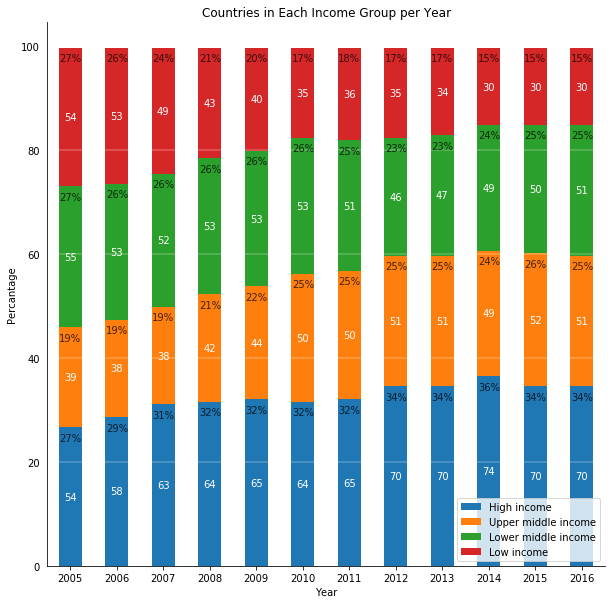

In [10]:
time_change()

<a id='Income Group Overview'></a>
## Income Group Overview 

Below is a plot showing the cumulative distribution of all income groups, along with summary statics and the suggested criteria for income group classification from the World Bank.  Countries fall into income groups based off of their GNI per capita:

| __  | Low income | Lower Middle Income | Upper Middle Income | High Income|
|-----|------------|---------------------|---------------------|------------|
| From | \$ 130 | \$ 890 | \$ 3,420 | \$ 9,890 |
| To | \$ 1,610 | \$ 5,550 | \$ 14,840 | \$ 121,650 |
| Average | \$ 631 | \$ 2,431 | \$ 7,386 | \$ 37,591 |
| Suggested Max | \$ 1,055 | \$ 3,955 | \$ 12,235 | \$ 100,000+|

Because of this information, we will be comparing our indicators to GNI per capita as they pertain to income groups while we look at how income groups differentiate themselves within each indicator.

<a href='#Table of Contents'>Table of Contents</a>


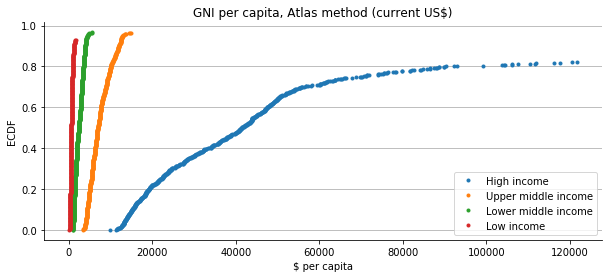

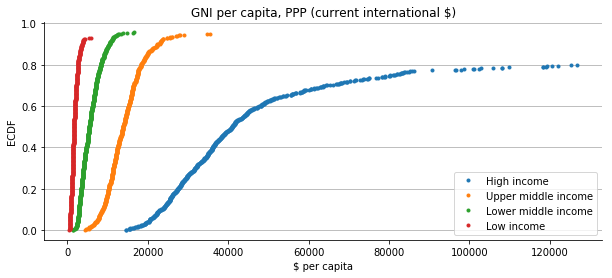

                               Suggested Classification Criteria
Low income max (L)                                          1045
Lower middle income max (LM)                                4125
Upper middle income  max (UM)                              12745
High income min (H)                                        12745


income_group,Low income,Lower middle income,Upper middle income,High income
count,436.00,593.00,536.00,646.00
mean,631.35,2431.03,7386.57,37591.16
std,277.70,995.06,2565.29,21624.08
min,130.00,890.00,3420.00,9890.00
25%,420.00,1520.00,5402.50,19367.50
50%,600.00,2320.00,6820.00,34410.00
75%,790.00,3230.00,9102.50,48547.50
max,1610.00,5550.00,14840.00,121650.00


In [11]:
gni_outlook()
print(income_group_criteria.iloc[:,[0,2,4,5]].max().to_frame()
      .rename(columns={0:'Suggested Classification Criteria'}))
gni_stats

In addition to analyzing our indicators, we will correlate them to GNI per capita.  Correlation scores will be seen as a + or - score between 0 and 1:
- 0.0 - 0.1 -- no correlation
- 0.1 - 0.2 -- very little correlation
- 0.2 - 0.3 -- little correlation
- 0.3 - 0.4 -- some correlation
- 0.4 - 0.6 -- correlated
- 0.6 - 0.7 -- a lot of correlation
- 0.7 - 0.8 -- very correlated
- 0.8 - 0.9 -- extremely correlated
- 0.9 - 1.0 -- directly correlated

<a id='Economic Policy and Debt'></a>
## Economic Policy and Debt 

____________

The indicators that pertained to economic policy and debt were:
- ***GNI per capita***
- ***GDP per capita, PPP***
- ***GDP growth (annual %)***
- ***External balance on goods and services (% of GDP)***

GNI and GDP both deal with the economic outlook of a country and are the deciding factors on what income group each country falls under.

External balance of goods and services is only positive among high income countries, 5.4%.  Among upper middle, lower middle and low income countries the balance is -49%, -12.8% and -17.85, respectively.  There are outliers on both ends for all income groups and they are countries that are expected to be outliers because of their surplus, scarcity or serious need/usage of all kinds of resources such as oil, minerals, etc.

    - Countries that have a large positive balance (over 40% of GDP) are Kuwait, Libya, Macao SAR China, Qatar, etc.
    - Countries that have a large negative balance (under 40% of GDP) are Afghanistan, Ghana, United States, United Kingdom, etc.


Annual GDP growth is larger among lower income countries than higher income countries.  Low income countries average a 5.4% annual GDP growth, followed by lower middle income, 4.7%, upper middle income, 3.4% and high income, 2.1% growth annually.  On average, low income countries outpace high income countries in annual GDP growth by 3.1% annually.  This is likely because of the room for growth, untapped resources, government policy, etc. 

<a href='#Table of Contents'>Table of Contents</a>
_______________

<a id='GNI per capita'></a>
#### GNI per capita, Atlas method (current US$) 


1. GNI per capita exponentially grows as the income group of a country becomes higher.  Low income countries have an average GNI per capita of 631.35 dollars.  Lower middle income, 2,431.03 dollars, upper middle income, 7,386.57 dollars and high income, 37,591.16 dollars.


2. There is a significant difference in means from income group to income group that exponentially grows as the income groups become higher.  From low to lower middle, the difference is 1,800 dollars, from lower middle to upper middle, the difference more than doubles, from upper middle to high, the difference is over 7x the difference from lower middle to upper middle.  The gap very is extreme.


3.  GNI per capita has roughly stayed the same from 2005 to 2016.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Economic Policy and Debt'>Economic Policy and Debt</a>

Indicator Definition: 

GNI per capita (formerly GNP per capita) is the gross national income, converted to U.S. dollars using the World Bank Atlas method, divided by the midyear population. GNI is the sum of value added by all resident producers plus any product taxes (less subsidies) not included in the valuation of output plus net receipts of primary income (compensation of employees and property income) from abroad. GNI, calculated in national currency, is usually converted to U.S. dollars at official exchange rates for comparisons across economies, although an alternative rate is used when the official exchange rate is judged to diverge by an exceptionally large margin from the rate actually applied in international transactions. To smooth fluctuations in prices and exchange rates, a special Atlas method of conversion is used by the World Bank. This applies a conversion factor that averages the exchange rate for a given year and the two preceding years, adjusted for differences in

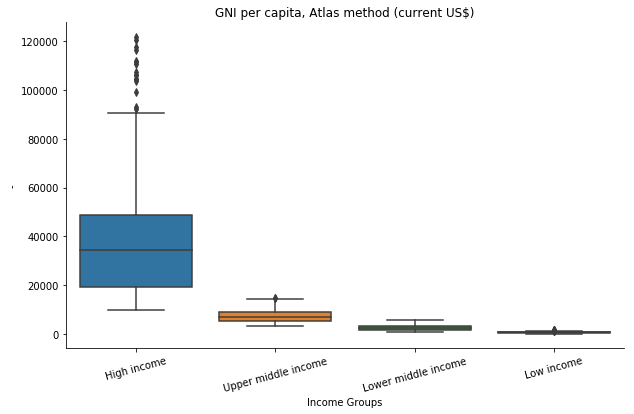


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group   High income  Upper mid income  Lower mid income  Low income
mean          37591.160991       7386.567164       2431.028668  631.353211


                Multiple Comparison of Means - Tukey HSD,FWER=0.05                
       group1              group2         meandiff     lower       upper    reject
----------------------------------------------------------------------------------
    High income          Low income     -36959.8078 -38835.3715 -35084.2441  True 
    High income     Lower middle income -35160.1323 -36881.0882 -33439.1765  True 
    High income     Upper middle income -30204.5938 -31972.6163 -28436.5714  True 
     Low income     Lower middle income  1799.6755   -109.3635   3708.7144  False 
     Low income     Upper middle income   6755.214   4803.6393   8706.7887   True 
Lower middle income U

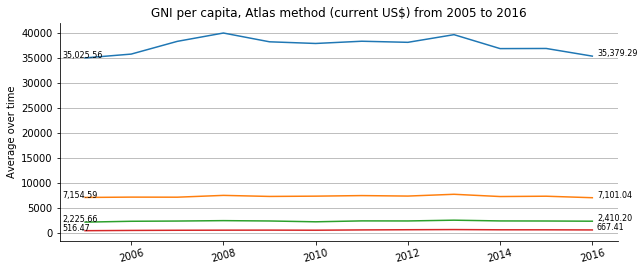

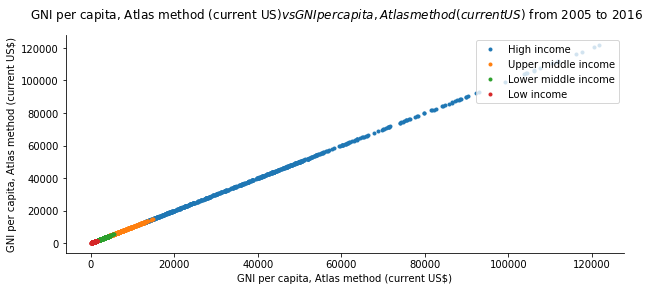

A deeper dive into each income group:


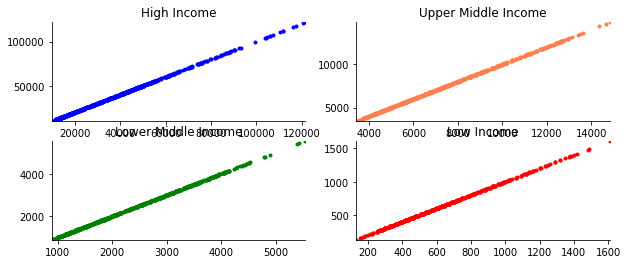

GNI per capita, Atlas method (current US$) and GNI per capita, Atlas method (current US$) are correlated by:
1.0000 with a p-value of 0.0 among all income groups
1.0000 with a p-value of 0.0 among High income countries.
1.0000 with a p-value of 0.0 among Upper middle income countries.
1.0000 with a p-value of 0.0 among Lower middle income countries.
1.0000 with a p-value of 0.0 among Low income countries.


In [12]:
view('GNI per capita, Atlas method (current US$)')

<a id='GDP per capita, PPP'></a>
#### GDP per capita, PPP (current international $)


1. GDP PPP per capita exponentially grows as the income group of a country becomes higher.  Low income countries have an average GDP PPP per capita of 1,828.62 dollars.  Lower middle income, 5,888.82 dollars, upper middle income, 14,653.56 dollars and high income, 43,470.71 dollars.  There are some countries that have GDP PPP that almost or more than double the average high income country GDP PPP:

        - Kuwait > $83k
        - Macao SAR, China > $96k
        - Luxembourg > $82k
        - Qatar > $120k
        - Singapore > $80k


2. There is a significant difference in means from income group to income group that more than doubles as the income groups become higher and even triples from upper middle income to high income countries.  The gap in purchasing power is extreme.


3.  From 2005 to 2016, high income countries have gained GDP PPP per capita while low income countries have lost GDP PPP per capita.


4. GDP PPP per capita is very positively correlated to GNI per capita with a pearson correlation score of 0.7938.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Economic Policy and Debt'>Economic Policy and Debt</a>

Indicator Definition: 

GDP per capita based on purchasing power parity (PPP). PPP GDP is gross domestic product converted to international dollars using purchasing power parity rates. An international dollar has the same purchasing power over GDP as the U.S. dollar has in the United States. GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. Data are in current international dollars based on the 2011 ICP round.


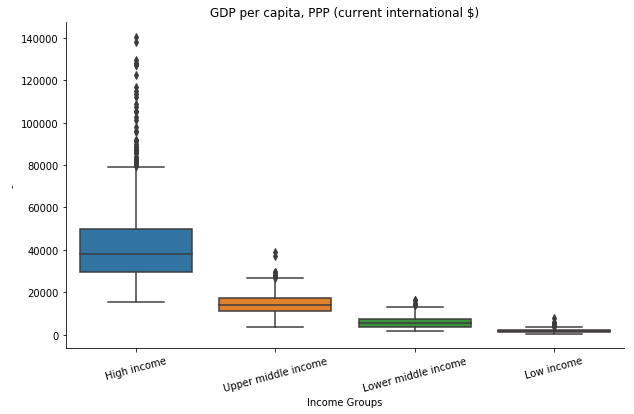


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income   Low income
mean          43470.70514      14653.561362       5888.817169  1828.620189


                Multiple Comparison of Means - Tukey HSD,FWER=0.05                
       group1              group2         meandiff     lower       upper    reject
----------------------------------------------------------------------------------
    High income          Low income      -41642.085 -43532.3049  -39751.865  True 
    High income     Lower middle income  -37581.888 -39324.1046 -35839.6714  True 
    High income     Upper middle income -28817.1438 -30609.7898 -27024.4977  True 
     Low income     Lower middle income   4060.197   2127.7818   5992.6122   True 
     Low income     Upper middle income  12824.9412  10846.9398  14802.9426  True 
Lower middle income U

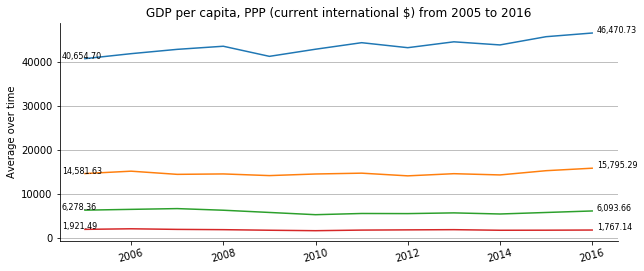

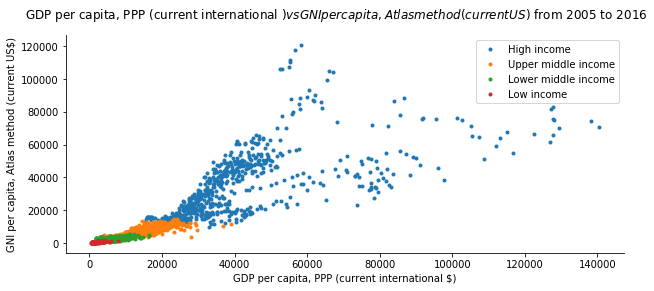

A deeper dive into each income group:


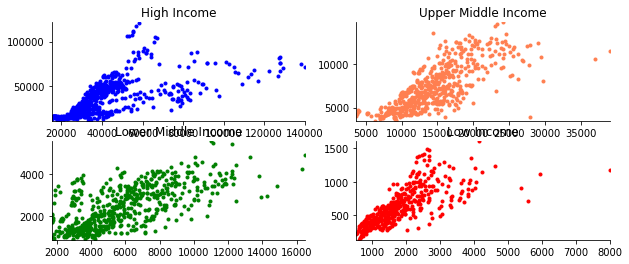

GDP per capita, PPP (current international $) and GNI per capita, Atlas method (current US$) are correlated by:
0.7938 with a p-value of 0.0 among all income groups
0.5705 with a p-value of 3.710117190466342e-69 among High income countries.
0.7377 with a p-value of 2.0590727178722174e-96 among Upper middle income countries.
0.6646 with a p-value of 2.33421500987805e-79 among Lower middle income countries.
0.7209 with a p-value of 2.1730702235715706e-76 among Low income countries.


In [13]:
view('GDP per capita, PPP (current international $)')

 <a id='GDP growth (annual %)'></a>
 #### GDP growth (annual %)


1. Annual GDP growth is larger among lower income countries than higher income countries.  Low income countries average 5.4%, lower middle income, 4.7%, upper middle income, 3.4% and high income, 2.1% growth annually.  This is likely because of the room for growth, untapped resources, government policy, etc.  There are some outliers that have seen extreme growth for more than one year.

    - Azerbaijan, lower middle income, saw over 25% GDP growth, annually, for 3 years.
    - Macao SAR, China, high income, saw over 20% GDP growth, annualy, for 2 years.
    - Timor-Leste, low income, saw over GDP growth between 20% and 40%, annually, for 3 years and moved to a lower middle income country.
    - Libya, considered an upper middle country, saw 123% GDP growth for one year.


2. There is a significant difference in means from income group to income group with the exception of comparing low income countries to lower middle income countries.  On average, low income countries outpace high income countries in annual GDP growth by 3.1% annually.


3. From 2005 to 2016, all income groups have dropped in GDP growth with high income and upper middle income countries having a negative GDP growth in 2009, likely because of the recession that occurred.  As of 2016, GDP growth among all income groups is within 1.2% of each other, with all but high income countries trending downwards.


4. Annual GDP growth has very little negative correlation to GNI per capita with a pearson correlation score of -0.1453. Individually, income groups have no correlation.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Economic Policy and Debt'>Economic Policy and Debt</a>

Indicator Definition: 

Annual percentage growth rate of GDP at market prices based on constant local currency. Aggregates are based on constant 2010 U.S. dollars. GDP is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources.


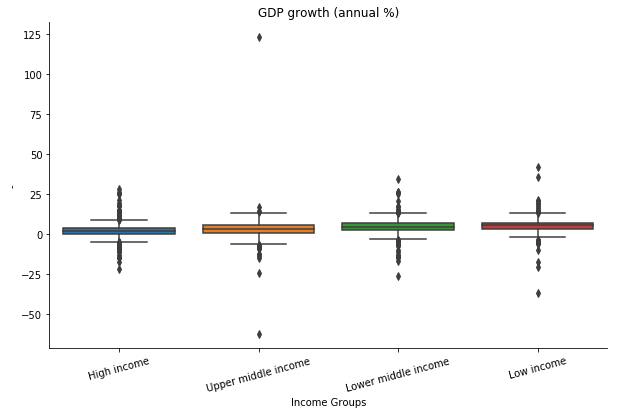


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             2.082931          3.390394          4.742591     5.40082


           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
       group1              group2       meandiff  lower   upper  reject
-----------------------------------------------------------------------
    High income          Low income      3.3179   2.4754  4.1604  True 
    High income     Lower middle income  2.6597   1.8892  3.4301  True 
    High income     Upper middle income  1.3075   0.5209  2.094   True 
     Low income     Lower middle income -0.6582   -1.539  0.2226 False 
     Low income     Upper middle income -2.0104  -2.9053 -1.1155  True 
Lower middle income Upper middle income -1.3522  -2.1797 -0.5247  True 
---------------------------------------

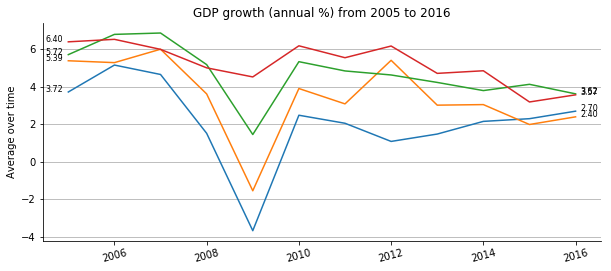

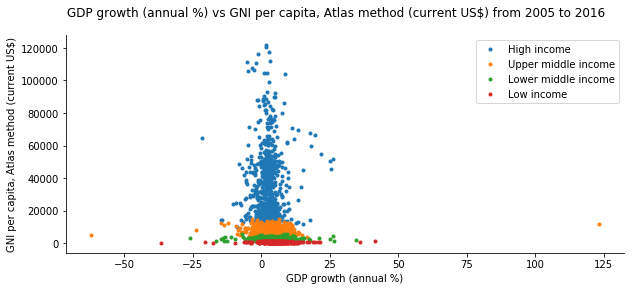

A deeper dive into each income group:


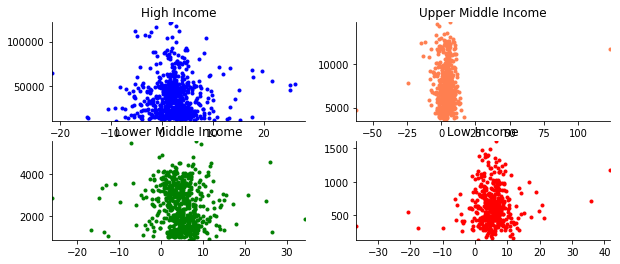

GDP growth (annual %) and GNI per capita, Atlas method (current US$) are correlated by:
-0.1453 with a p-value of 6.642479370954641e-13 among all income groups
0.0202 with a p-value of 0.5709795312209296 among High income countries.
0.0314 with a p-value of 0.46030778690741014 among Upper middle income countries.
-0.1057 with a p-value of 0.008839869167595117 among Lower middle income countries.
0.0531 with a p-value of 0.2511458525791927 among Low income countries.


In [14]:
view('GDP growth (annual %)')

<a id='External balance on goods and services (% of GDP)'></a>
#### External balance on goods and services (% of GDP) 


1. External balance of goods and services is only positive among high income countries, 5.4%.  Among upper middle, lower middle and low income countries the balance is -49%, -12.8% and -17.85, respectively.  There are outliers on both ends for all income groups and they are countries that are expected to be outliers because of their surplus, scarcity or serious need/usage of all kinds of resources such as oil, minerals, etc.

    - Countries that have a large positive balance (over 40% of GDP) are: 
            - Kuwait, Libya, Macao SAR China, Qatar, etc.
    - Countries that have a large negative balance (under 40% of GDP) are: 
            - Afghanistan, Ghana, United States, United Kingdom, etc.


2. There is a significant difference in means from income group to income group with high income countries and low income countries having a difference in balances by 23.1%. From lower income to higher income countries, the difference in balance of goods and services increases from 4.9% to 8% to 10.2%.


3. All income groups have seen a drop in balance of goods in services from 2005 to 2016.  Again this is likely due to the outliers on both ends, especially the countries that have a serious need/usage of goods and services.


4. External balance of goods and services has some positive correlation to GNI per capita with a pearson correlation score of 0.3813.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Economic Policy and Debt'>Economic Policy and Debt</a>

Indicator Definition: 

External balance on goods and services (formerly resource balance) equals exports of goods and services minus imports of goods and services (previously nonfactor services).


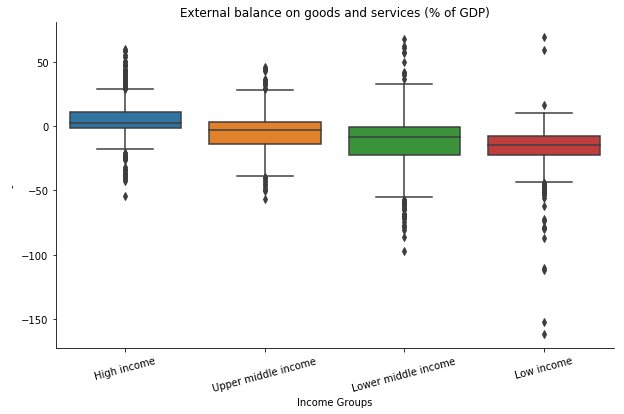


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             5.359238         -4.853636        -12.849503  -17.790154


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -23.1494 -26.0654 -20.2334  True 
    High income     Lower middle income -18.2087 -20.9042 -15.5133  True 
    High income     Upper middle income -10.2129 -12.9309 -7.4948   True 
     Low income     Lower middle income  4.9407   1.9265   7.9548   True 
     Low income     Upper middle income 12.9365   9.9022  15.9708   True 
Lower middle income Upper middle income  7.9959   5.1728  10.8189   True 
---------------------

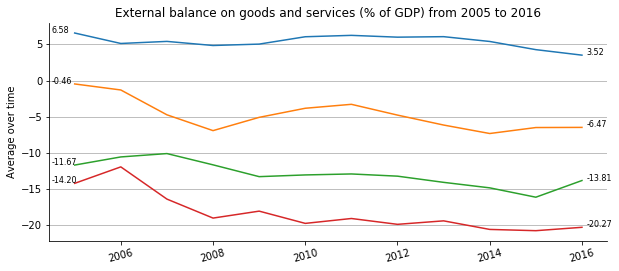

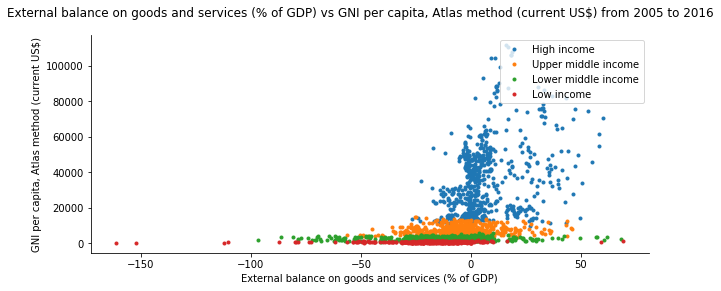

A deeper dive into each income group:


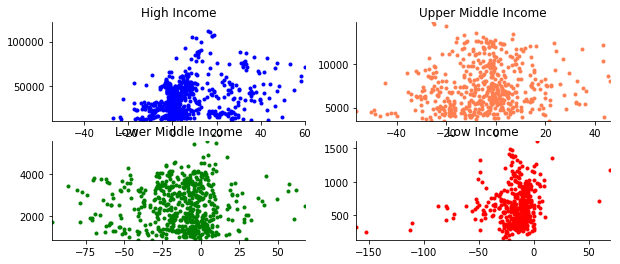

External balance on goods and services (% of GDP) and GNI per capita, Atlas method (current US$) are correlated by:
0.3813 with a p-value of 1.0128464627800903e-84 among all income groups
0.2346 with a p-value of 2.659170824265074e-11 among High income countries.
0.1396 with a p-value of 0.0009773196589800892 among Upper middle income countries.
0.0036 with a p-value of 0.929468797859161 among Lower middle income countries.
0.1444 with a p-value of 0.0017229452619548435 among Low income countries.


In [15]:
view('External balance on goods and services (% of GDP)')

<a id='Education and Gender Issues'></a>
## Education and Gender Issues 

____________

The indicators that pertained to education and gender issues dealt with:
- ***duration of compulsory education***
- ***proportion of seats held by women in national parliaments***

The average required amount of years for schooling among all income groups is between 8 and 10 years with little correlation to GNI per capita.

The proportion of seats held by women in national parliaments ranges between 21.8% and 17.5% for all income groups which is a 4.3% difference in means.  However, there are some countries that have a proportion of seats held by women in national parliaments between 40% and 60% which leads to very little correlation to GNI per capita.

<a href='#Table of Contents'>Table of Contents</a>
_______________

<a id='duration of compulsory education'></a>
#### Compulsory education, duration (years) 


1. The average required amount of years for schooling is 10.2 for high and upper middle income countries, 9.2 for lower middle income countries and 8 for low income countries.


2. The difference in means for required schooling between high and low income countries is 2.3 years.


3. There are no significant changes from 2005 to 2016 in the required amount of schooling among income groups with the exception of lower middle income countries requiring, on average 1 more year of schooling from just under 9 to under 10.


4. Compulsory education has very little positive correlation to GNI per capita with a pearson correlation score of 0.1938.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Education and Gender Issues'>Education and Gender Issues</a>

Indicator Definition: 

Duration of compulsory education is the number of years that children are legally obliged to attend school.


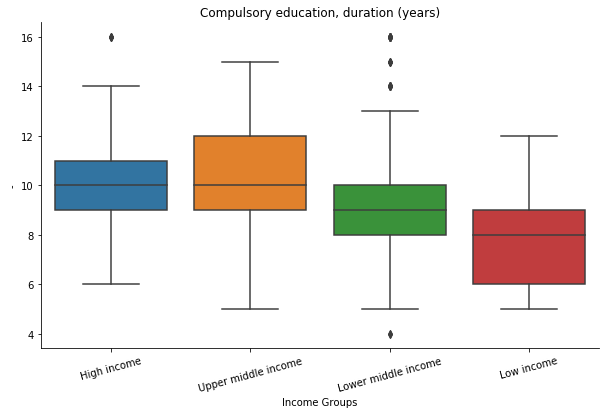


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            10.174298         10.111328          9.207477    7.900262


           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
       group1              group2       meandiff  lower   upper  reject
-----------------------------------------------------------------------
    High income          Low income      -2.274  -2.6094 -1.9386  True 
    High income     Lower middle income -0.9668  -1.2698 -0.6639  True 
    High income     Upper middle income  -0.063  -0.3697  0.2437 False 
     Low income     Lower middle income  1.3072   0.9562  1.6583  True 
     Low income     Upper middle income  2.2111   1.8567  2.5654  True 
Lower middle income Upper middle income  0.9039   0.5801  1.2276  True 
---------------------------------------

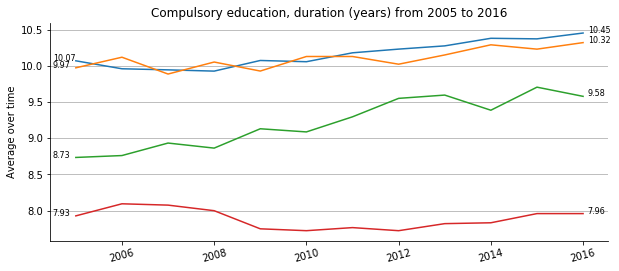

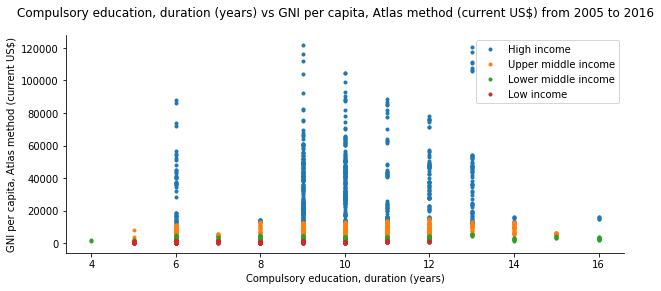

A deeper dive into each income group:


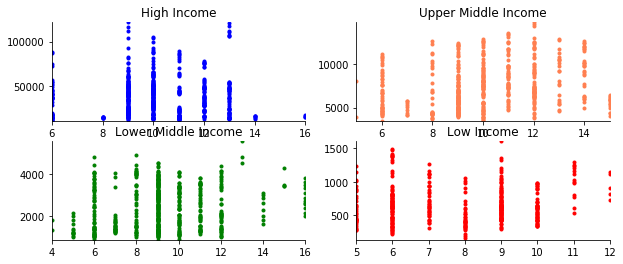

Compulsory education, duration (years) and GNI per capita, Atlas method (current US$) are correlated by:
0.1938 with a p-value of 6.116847753184009e-22 among all income groups
0.0147 with a p-value of 0.6807092558039047 among High income countries.
0.2293 with a p-value of 4.669682434425437e-08 among Upper middle income countries.
0.1421 with a p-value of 0.000415448914164105 among Lower middle income countries.
0.0709 with a p-value of 0.12522847676620127 among Low income countries.


In [16]:
view('Compulsory education, duration (years)')

<a id='proportion of seats held by women in national parliaments'></a>
#### Proportion of seats held by women in national parliaments (%) 


1. The proportion of seats held by women in national parliaments is 21.8% for high income countries, 18.1% for upper middle, 14.9% for lower middle and 17.5% for low income countries.


2. The difference in means of the proportion of seats held by women in national parliaments from high income countries to low income countries is 4.3%.  Although from income group to income group the differences are significant, they are very small as a whole, with upper middle income and low income countries having no real difference in proportions.  But there are outliers.


3. From 2005 to 2016, all income groups have seen a growth in the proportion of seats held by women in national parliaments, likely due to evolving gender roles and acceptance of women as leaders.


4. Proportions for high income countries have some positive correlation to GNI per capita with a pearson correlation score of 0.3061, while there is little negative, to no, correlation among the rest of the income groups. 

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Education and Gender Issues'>Education and Gender Issues</a>

Indicator Definition: 

Women in parliaments are the percentage of parliamentary seats in a single or lower chamber held by women.


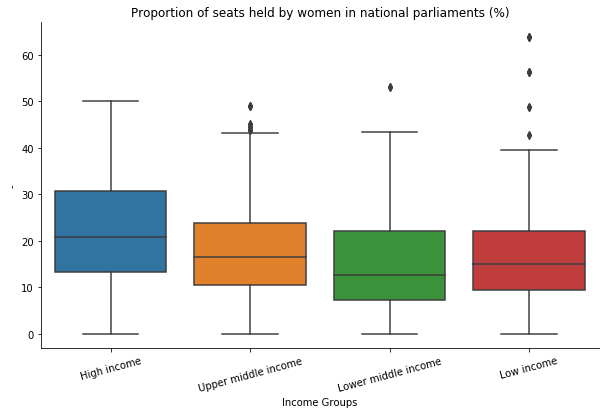


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            21.861478         18.104511         14.902369   17.533929


           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
       group1              group2       meandiff  lower   upper  reject
-----------------------------------------------------------------------
    High income          Low income     -4.3275  -6.0828 -2.5723  True 
    High income     Lower middle income -6.9591  -8.5868 -5.3314  True 
    High income     Upper middle income  -3.757  -5.4301 -2.0839  True 
     Low income     Lower middle income -2.6316  -4.4024 -0.8607  True 
     Low income     Upper middle income  0.5706  -1.2421  2.3832 False 
Lower middle income Upper middle income  3.2021   1.5127  4.8916  True 
---------------------------------------

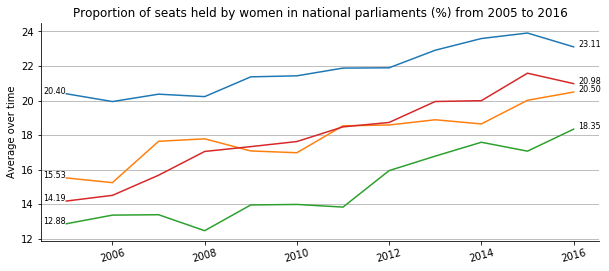

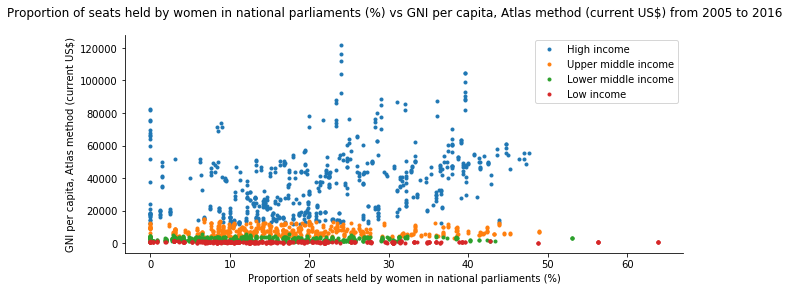

A deeper dive into each income group:


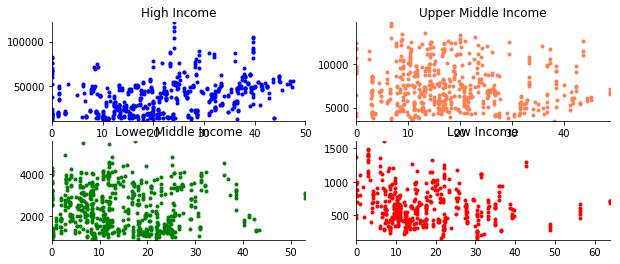

Proportion of seats held by women in national parliaments (%) and GNI per capita, Atlas method (current US$) are correlated by:
0.2385 with a p-value of 1.0378504098190785e-32 among all income groups
0.3061 with a p-value of 1.5575482633756884e-18 among High income countries.
-0.0915 with a p-value of 0.031231561309848055 among Upper middle income countries.
-0.0540 with a p-value of 0.18156935890461973 among Lower middle income countries.
-0.1651 with a p-value of 0.00033122872199546106 among Low income countries.


In [17]:
view('Proportion of seats held by women in national parliaments (%)')

<a id='Access to Advanced Communications'></a>
## Access to Advanced Communications 

____________

The indicators that pertained to access to advanced communications dealt with:
- ***individuals using the internet***
- ***mobile cellular subscriptions***

Internet usage varies exponentially among income groups.  67.6% of individuals in high income countries use the internet as opposed to 36.8%, 17.8% and 4.9% of individuals in upper middle, lower middle and low income countries, respectively.  With the prevalence of the internet, usage appears considerably low.  This is likely due to differences in age and population location (rural vs. urban).  Over time, all income groups have seen a rise in their populations using the internet, which is very much correlated to GNI per capita.

Mobile cellular subscriptions increase with the income level of a country.  Low income countries have a subscription rate of 35.7 while lower middle income countries have a rate of 68.5, upper middle, 102, and high income countries, 118.3.  From 2005 to 2016 all income groups have seen a large increase in mobile cellular subscriptions rates ranging between a 50 and 60 rate increase per group.

<a href='#Table of Contents'>Table of Contents</a>

_______________

 <a id='individuals using the internet'></a>
 #### Individuals using the Internet (% of population)


1. Internet usage varies exponentially among income groups.  67.6% of individuals in high income countries use the internet as opposed to 36.8% of individuals in upper middle income countries, 17.8% in lower income countries and 4.9% in low income countries.  With the prevalence of the internet, usage is considerably low.  This is likely due to differences of age and population location (rural vs. urban).


2. There is a significant difference in means from income group to income group with 62.7% more of the population in high income countries using the internet than low income countries.  The difference from high income countries to upper middle income countries is over 30% and converges to 13% from income group to income group as the income groups lower.


3. With the exception of low income countries, 9%, all income groups have seen a rise in their populations using the internet by over 25%


4. Internet usage is very much correlated to GNI per capita with a pearson correlation score of 0.7013.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Access to Advanced Communications'>Access to Advanced Communications</a>

Indicator Definition: 

Internet users are individuals who have used the Internet (from any location) in the last 3 months. The Internet can be used via a computer, mobile phone, personal digital assistant, games machine, digital TV etc.


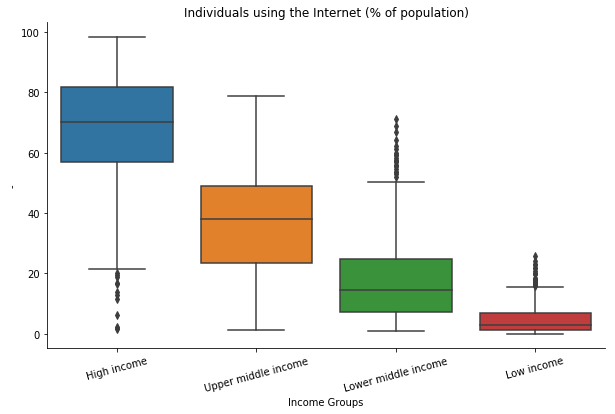


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            67.563083         36.794654          17.82059    4.881881


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -62.6812 -65.0438 -60.3186  True 
    High income     Lower middle income -49.7425 -51.9143 -47.5707  True 
    High income     Upper middle income -30.7684 -33.029  -28.5079  True 
     Low income     Lower middle income 12.9387  10.4777  15.3997   True 
     Low income     Upper middle income 31.9128  29.3731  34.4524   True 
Lower middle income Upper middle income 18.9741  16.6109  21.3372   True 
---------------------

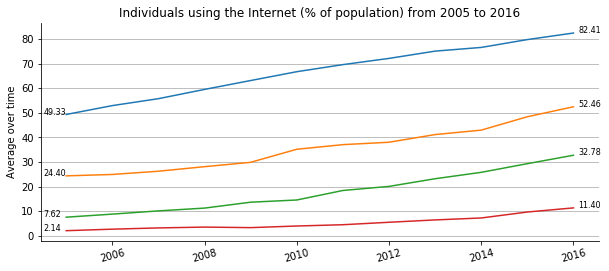

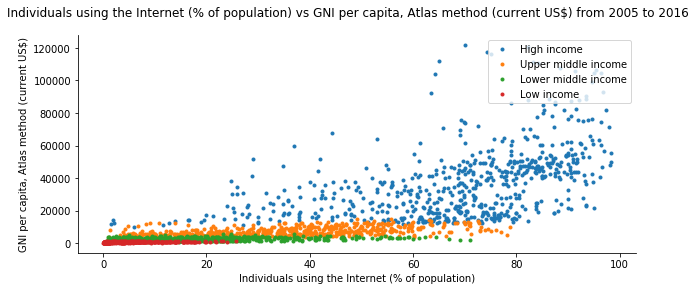

A deeper dive into each income group:


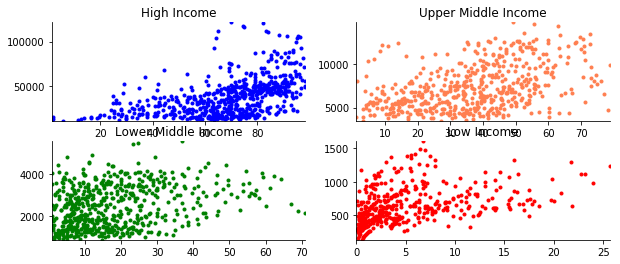

Individuals using the Internet (% of population) and GNI per capita, Atlas method (current US$) are correlated by:
0.7013 with a p-value of 0.0 among all income groups
0.4220 with a p-value of 2.449443713086723e-35 among High income countries.
0.4212 with a p-value of 2.82825164423663e-25 among Upper middle income countries.
0.3161 with a p-value of 1.093632741087716e-15 among Lower middle income countries.
0.3942 with a p-value of 6.997060762571797e-19 among Low income countries.


In [18]:
view('Individuals using the Internet (% of population)')

 <a id='mobile cellular subscriptions'></a>
 #### Mobile cellular subscriptions (per 100 people)


1. Mobile cellular subscriptions increase with the income level of a country.  Low income countries have a subscription rate of 35.7 while lower middle income countries have a rate of 68.5, upper middle, 102, and high income countries, 118.3.


2. There is a significant difference in means from income group to income group with a 82.6 rate increase from high income countries to low income countries.  Upper middle income countries are close in subscription rates to high income countries with a difference of 16, but lower middle and low income country rates drop by 33, each.


3. From 2005 to 2016 all income groups have seen a large increase in mobile cellular subscriptions rates ranging between a 50 and 60 rate increase per group.

4. Although, mobile cellular subscription rates have no correlation to GNI per capita among high income countries, as a whole, mobile cellular subscription rates among all income groups are positively correlated to to GNI per capita with a pearson correlation score of 0.4112.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Access to Advanced Communications'>Access to Advanced Communications</a>

Indicator Definition: 

Mobile cellular telephone subscriptions are subscriptions to a public mobile telephone service that provide access to the PSTN using cellular technology. The indicator includes (and is split into) the number of postpaid subscriptions, and the number of active prepaid accounts (i.e. that have been used during the last three months). The indicator applies to all mobile cellular subscriptions that offer voice communications. It excludes subscriptions via data cards or USB modems, subscriptions to public mobile data services, private trunked mobile radio, telepoint, radio paging and telemetry services.


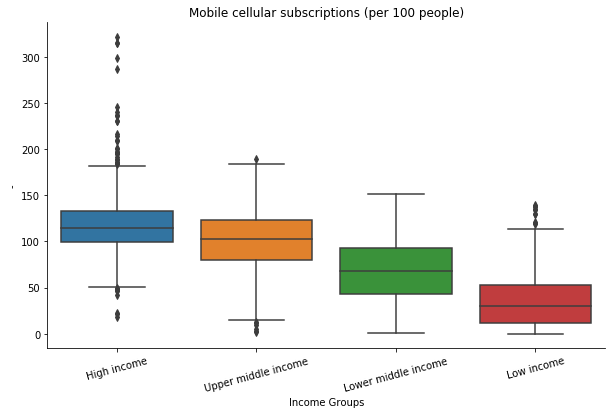


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean           118.281136        101.933647         68.470787   35.674523


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -82.6066 -87.8162 -77.397   True 
    High income     Lower middle income -49.8103 -54.6465 -44.9742  True 
    High income     Upper middle income -16.3475 -21.3405 -11.3545  True 
     Low income     Lower middle income 32.7963  27.3858  38.2067   True 
     Low income     Upper middle income 66.2591   60.708  71.8102   True 
Lower middle income Upper middle income 33.4629  28.2606  38.6651   True 
---------------------

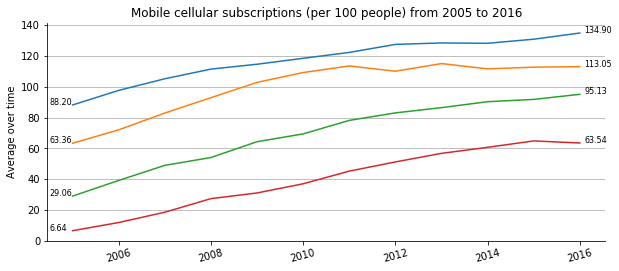

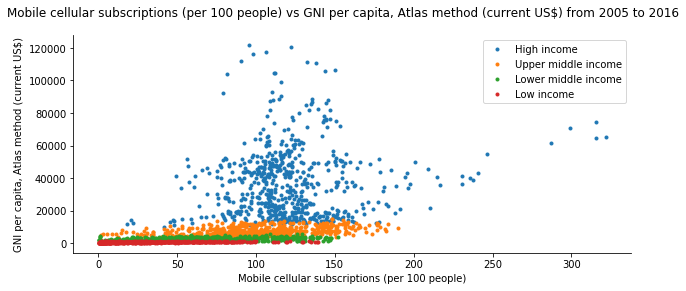

A deeper dive into each income group:


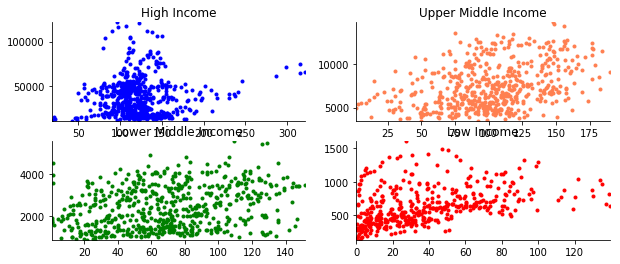

Mobile cellular subscriptions (per 100 people) and GNI per capita, Atlas method (current US$) are correlated by:
0.4412 with a p-value of 5.0369875762197085e-116 among all income groups
0.0804 with a p-value of 0.024156206845941674 among High income countries.
0.3672 with a p-value of 3.703145509343801e-19 among Upper middle income countries.
0.2615 with a p-value of 4.795610192540524e-11 among Lower middle income countries.
0.3876 with a p-value of 2.9236209296826543e-18 among Low income countries.


In [19]:
view('Mobile cellular subscriptions (per 100 people)')

<a id='Environment, Resources and Population'></a>
## Environment, Resources and Population 

____________

The indicators that pertained to environment, resources and population involved:
- ***access to electricity***
- ***access to clean technology and fuels for cooking***
- ***total natural resources rents***
- ***urban and rural population***

Access to electricity is extremely prevalent among high and upper middle income countries with over 94% of their populations having access.  Lower middle income countries have the widest range in access but average 77.4%, while low income countries average 33%.  There is a significant difference in means with 66.5% more of the population in high income countries having access to electricity than low income countries.  The gap from low income countries to lower middle income countries is extremely wide as well with a 44.5% difference in population access.

Access to clean fuels and technologies for cooking is extremely prevalent at 98% and 84.4%, respectively, among high and upper middle income countries.  Lower middle income countries average 49.8%, while low income countries average only 10.9%.  From upper middle to lower middle and from lower middle to low income countries, the difference in means ranges between 30% and 40%.  This may relate to access to electricity as the visual depictions of the data look identical.  From 2005 to 2016, lower income countries are losing access to clean fuels and technologies for cooking with lower middle income countries dropping 13% and low income countries dropping 6%.

Total natural resources rents are 4.9% of the total GDP for high income countries and rises to 12.2% for low income countries.  There are several outliers in each income group that go up to 70% of a country's total GDP, which means that a few countries, regardless of income group, produce most of the natural resources involved in oil, natural gases, coal, minerals and forests.  Because of the wide variety of outliers, natural resources rents have very little negative, almost no, correlation to GNI per capita.

There is a significant difference in means of urban population to total population from income group to income group of about 12% to 15% with high income countries (77%) having 44.5% more of its total population in urban areas than low income countries (32.4%).  This is likely due to the differences in workforce which can be seen in the social protection and labor section.  Urban population is directly negatively correlated to rural population.

<a href='#Table of Contents'>Table of Contents</a>

_______________

 <a id='access to electricity'></a>
 #### Access to electricity (% of population)


1. Access to electricity is extremely prevalent among higher income countries with 99.5% of the population of high income countries and 94.2% of upper middle income countries having access.  Lower middle income countries have the widest range in access between roughly 15% and 95% but average 77.4%.  Low income countries average only 33% of their populations having access to electricity.


2. There is a significant difference in means from income group to income group with 66.5% more of the population in high income countries having access to electricity than low income countries.  From upper middle to lower middle and from lower middle to low income countries, the difference in means 16.7% and 44.5%, respectively.  The gap from low income countries on up is extremely wide.


3.  Although lower middle income countries have seen a 5% drop in access to electricity from 2005 to 2016, access to electricity among all income groups have remained roughly the same.


4. Access to electricity is positively correlated to GNI per capita with a pearson correlation score of 0.4101.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Environment, Resources and Population'>Environment, Resources and Population</a>

Indicator Definition: 

Access to electricity is the percentage of population with access to electricity. Electrification data are collected from industry, national surveys and international sources.


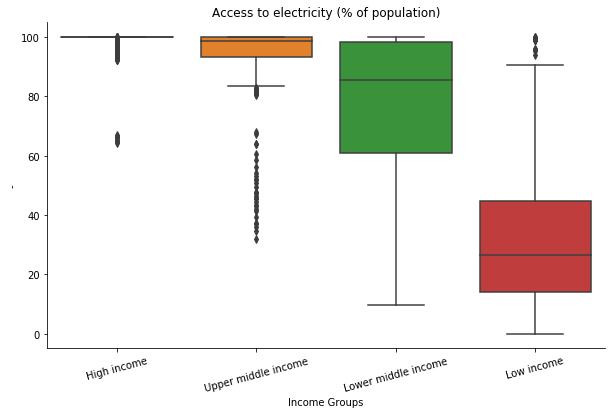


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             99.46051         94.158634         77.433313   32.984324


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -66.4762 -69.066  -63.8864  True 
    High income     Lower middle income -22.0272 -24.4188 -19.6356  True 
    High income     Upper middle income -5.3019  -7.7813  -2.8224   True 
     Low income     Lower middle income  44.449  41.7254  47.1726   True 
     Low income     Upper middle income 61.1743  58.3733  63.9754   True 
Lower middle income Upper middle income 16.7253  14.1064  19.3442   True 
---------------------

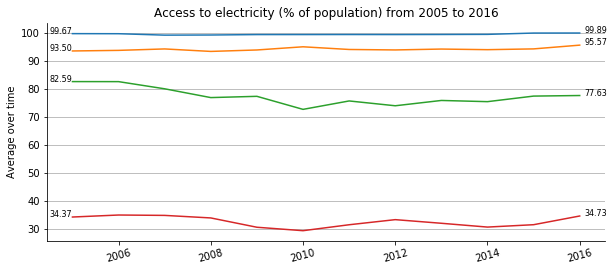

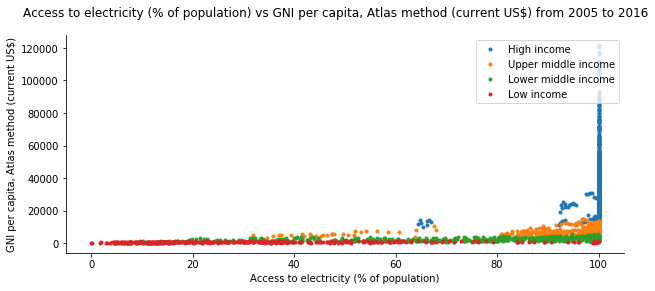

A deeper dive into each income group:


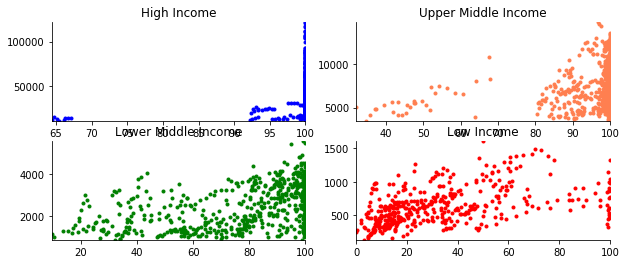

Access to electricity (% of population) and GNI per capita, Atlas method (current US$) are correlated by:
0.4101 with a p-value of 5.755910043308637e-99 among all income groups
0.1761 with a p-value of 6.663117953771475e-07 among High income countries.
0.2478 with a p-value of 3.2551064939104474e-09 among Upper middle income countries.
0.4235 with a p-value of 4.509488566221593e-28 among Lower middle income countries.
0.4605 with a p-value of 5.364548384266386e-26 among Low income countries.


In [20]:
view('Access to electricity (% of population)')

 <a id='access to clean technology and fuels for cooking'></a>
#### Access to clean fuels and technologies for cooking (% of population)


1. Access to clean fuels and technologies for cooking is extremely prevalent among higher income countries with 98% of the population of high income countries and 84.4% of upper middle income countries having access.  Lower middle income countries have the widest range in access between roughly 20% and 80% but average 49.8%.  Low income countries average only 10.9% of their populations having access to clean fuels and technologies for cooking.


2. There is a significant difference in means from income group to income group with 87% more of the population in high income countries having access to clean fuels and technologies for cooking than low income countries.  From upper middle to lower middle and from lower middle to low income countries, the difference in means ranges between 30% and 40%.  This may relate to access to electricity because data for income groups and changes over time for both indicators look identical.


3. From 2005 to 2016, lower income countries are losing access to clean fuels and technologies for cooking with lower middle income countries dropping from 60% of their populations having access to 47% and low income countries dropping from 13.6% to 7.3%.


4. Access to clean fuels and technologies for cooking is positively correlated to GNI per capita with a pearson correlation score of 0.4779.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Environment, Resources and Population'>Environment, Resources and Population</a>

Indicator Definition: 

Access to clean fuels and technologies for cooking is the proportion of total population primarily using clean cooking fuels and technologies for cooking. Under WHO guidelines, kerosene is excluded from clean cooking fuels.


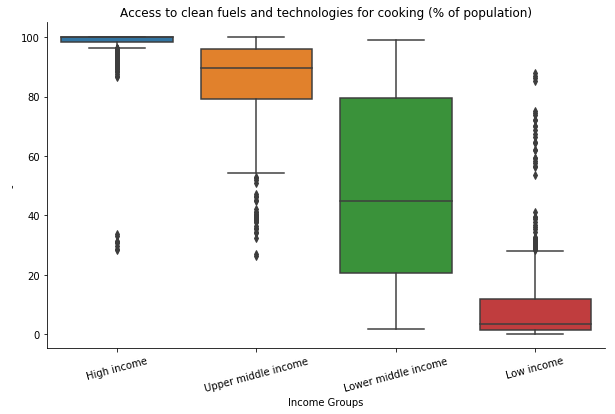


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            97.839573         84.415386         49.803198    10.85398


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -86.9856 -90.1483 -83.8229  True 
    High income     Lower middle income -48.0364 -50.9964 -45.0764  True 
    High income     Upper middle income -13.4242 -16.5226 -10.3258  True 
     Low income     Lower middle income 38.9492  35.7774  42.1211   True 
     Low income     Upper middle income 73.5614   70.26   76.8628   True 
Lower middle income Upper middle income 34.6122  31.5045  37.7199   True 
---------------------

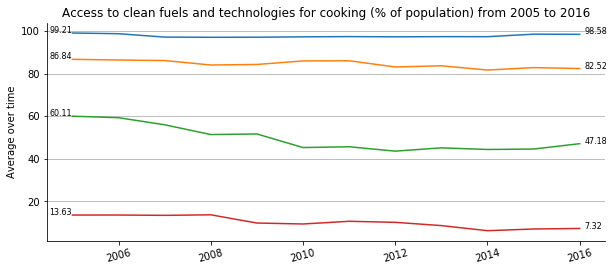

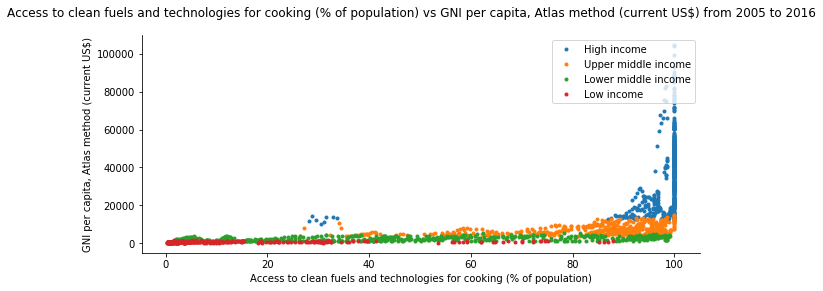

A deeper dive into each income group:


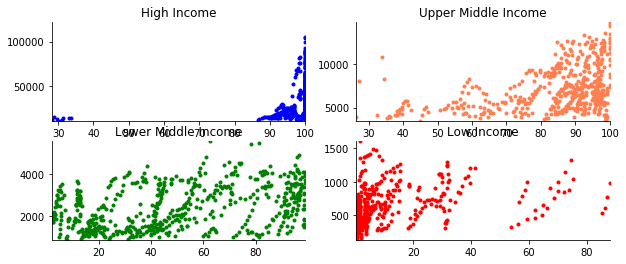

Access to clean fuels and technologies for cooking (% of population) and GNI per capita, Atlas method (current US$) are correlated by:
0.4779 with a p-value of 1.5768191551296408e-138 among all income groups
0.2275 with a p-value of 1.0681636886191988e-10 among High income countries.
0.3797 with a p-value of 1.7890768322463052e-20 among Upper middle income countries.
0.3618 with a p-value of 2.1492899460769553e-20 among Lower middle income countries.
0.3080 with a p-value of 9.155121001570322e-12 among Low income countries.


In [21]:
view('Access to clean fuels and technologies for cooking (% of population)')

<a id='total natural resources rents'></a>
#### Total natural resources rents (% of GDP) 


1. Total natural resources rents are 4.9% of the total GDP for high income countries and rises to 12.2% for low income countries.  There are several outliers in each income group that go up to 70% of a country's total GDP, which means that a few countries, regardless of income group, produce most of the natural resources involved in oil, natural gases, coal, minerals and forests.


2. There is a small significant difference in means between each income group ranging from 2% to 3% from income group to income group.


3. From 2005 to 2016, low income countries were the only ones to see an increase in total natural resources rents as it pertains to the total of a country's GDP.


4. Because of the wide variety of outliers, natural resources rents have very little negative, almost no, correlation to GNI per capita with a pearson correlation scor of -0.1559 among all income groups and under -0.1 among most individually.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Environment, Resources and Population'>Environment, Resources and Population</a>

Indicator Definition: 

Total natural resources rents are the sum of oil rents, natural gas rents, coal rents (hard and soft), mineral rents, and forest rents.


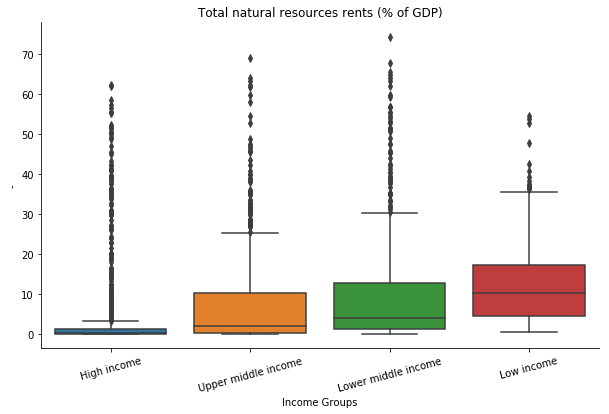


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean              4.90772          7.986581          9.890122   12.173989


           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
       group1              group2       meandiff  lower   upper  reject
-----------------------------------------------------------------------
    High income          Low income      7.2663   5.3535  9.1791  True 
    High income     Lower middle income  4.9824   3.2376  6.7272  True 
    High income     Upper middle income  3.0789   1.2903  4.8675  True 
     Low income     Lower middle income -2.2839  -4.2756 -0.2922  True 
     Low income     Upper middle income -4.1874  -6.2176 -2.1573  True 
Lower middle income Upper middle income -1.9035  -3.7763 -0.0308  True 
---------------------------------------

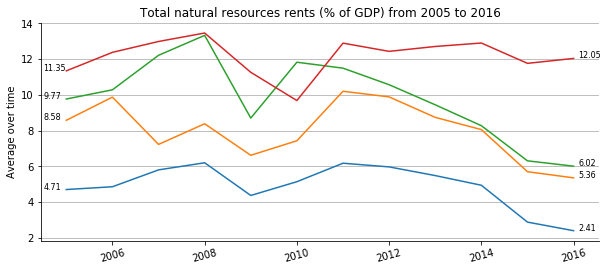

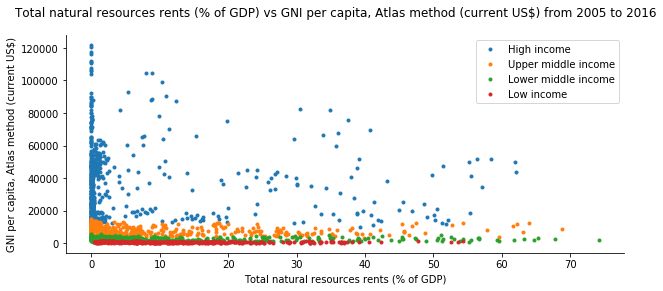

A deeper dive into each income group:


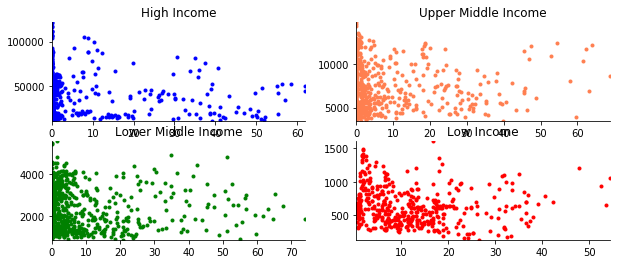

Total natural resources rents (% of GDP) and GNI per capita, Atlas method (current US$) are correlated by:
-0.1559 with a p-value of 1.1699642110931364e-14 among all income groups
-0.0663 with a p-value of 0.06319382407748379 among High income countries.
-0.0213 with a p-value of 0.6162787783094417 among Upper middle income countries.
-0.0959 with a p-value of 0.01755191102998266 among Lower middle income countries.
-0.1309 with a p-value of 0.004520420672168953 among Low income countries.


In [22]:
view('Total natural resources rents (% of GDP)')

<a id='urban and rural population'></a>
#### Urban population (% of total) 


1. The total population comprises mostly of urban population among higher income countries and mostly of rural population among lower income countries.  Urban population is 77% among high income countries, 64.7% among upper middle countries, 48% among lower middle countries, and 32.4% among low income countries.


2. There is a significant difference in means of urban population to total population from income group to income group of about 12% to 15% with high income countries having 44.5% more of its total population in urban areas than low income countries.  This is likely due to the differences in workforce which can be seen in the social protection and labor section.


3. From 2005 to 2016, lower middle income countries have seen a 6% drop in urban population totals, while low income countries have seen a 3% rise in their urban populations.  High and upper middle income countries stayed roughly the same over time.


4. Individually, urban population has very little correlation among income groups to GNI per capita.  But as a whole, there is a positive correlation between urban population and GNI per capita.  Also, urban population is directly negatively correlated to rural population.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Environment, Resources and Population'>Environment, Resources and Population</a>

Indicator Definition: 

Urban population refers to people living in urban areas as defined by national statistical offices. The data are collected and smoothed by United Nations Population Division.


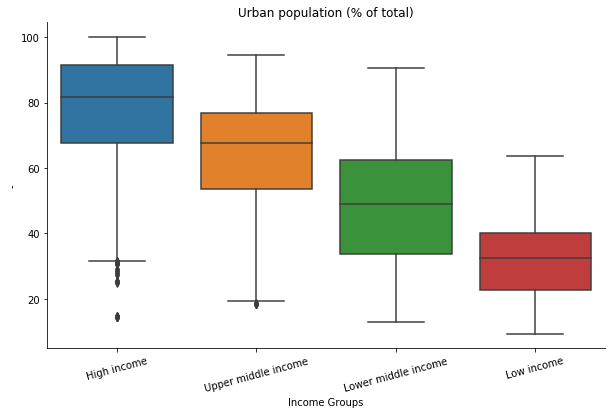


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            76.975764           64.7234         47.992334   32.397877


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -44.5779 -47.1532 -42.0025  True 
    High income     Lower middle income -28.9834 -31.3537 -26.6131  True 
    High income     Upper middle income -12.2524 -14.6913 -9.8134   True 
     Low income     Lower middle income 15.5945  12.8869   18.302   True 
     Low income     Upper middle income 32.3255  29.5577  35.0933   True 
Lower middle income Upper middle income 16.7311   14.153  19.3092   True 
---------------------

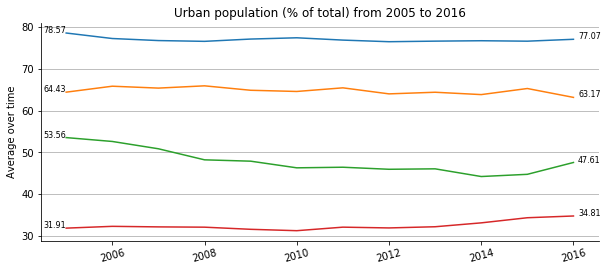

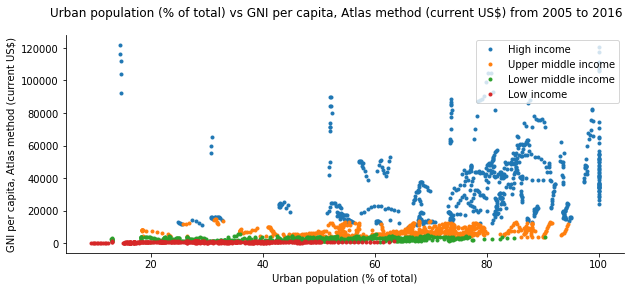

A deeper dive into each income group:


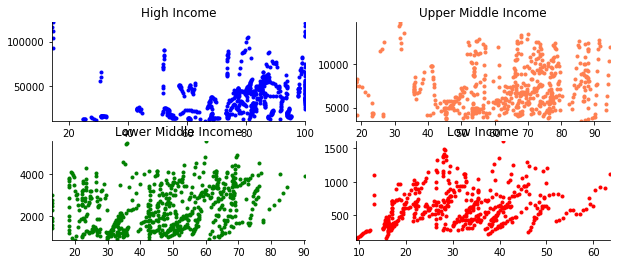

Urban population (% of total) and GNI per capita, Atlas method (current US$) are correlated by:
0.5060 with a p-value of 9.579709774864412e-158 among all income groups
0.1921 with a p-value of 5.5937249211300266e-08 among High income countries.
0.1272 with a p-value of 0.002684989711165094 among Upper middle income countries.
0.2545 with a p-value of 1.6217634111624362e-10 among Lower middle income countries.
0.1916 with a p-value of 2.9434843423808736e-05 among Low income countries.


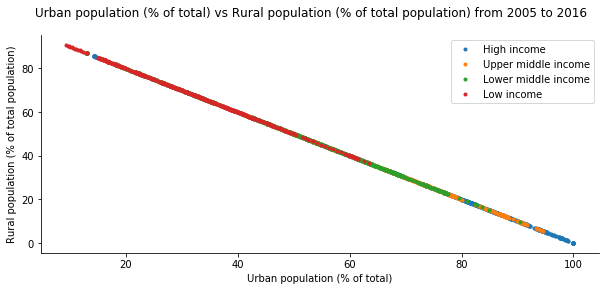

Urban population (% of total) and Rural population (% of total population) are correlated by:
-1.0000 with a p-value of 0.0 among all income groups


In [23]:
view('Urban population (% of total)')
# Correlation between urban and rural population
urban_rural()

<a id='Social Protection and Labor'></a>
## Social Protection and Labor 

____________

The indicators that pertained to social protection and labor were:
- ***labor force participation***
- ***contributing family workers***
- ***dependents of the workforce***
- ***employment in agriculture***
- ***employment in industry***
- ***employment in service***

Labor force participation is roughly the same for high income countries and low income countries at 71%, and is on the rise.  It drops to under 65% percent for upper middle and lower middle income countries.  It is possible that the need to work in low income countries to survive and the need to work in high income countries to maintain lifestyle is why they are just about even.

Contributing family workers are those who work with family members who operate their own businesses.  High income countries have only 1% of their total workforce as contributing family workers, while the rate exponentially rises as income groups become lower with one quarter of the workforce in low income countries being contributing family members.  This is likely due to the need to work as a community within a household in order to survive as income categories lessen.  For example, a family in a third world country may own and operate a small grocery store from within their house, or parents employing their children in a restaurant.

The ratio of dependents to the working population grows as income groups become lower.  High income countries have a dependency ratio of 46.5% and the ratio rises to 83.9% among low income countries.  This is likely due to the increased rate of fertility for women in lower income countries coupled with the possibility that people over 64 years of age are more likely to have retirement funds in higher income countries.

Employment in services is extremely high among high income countries with 71.8% of the total workforce in that sector.  The difference in means from income group to income group ranges between 12% and 17%.  While high income countries have 7 in 10 people from their total workforce in industry, low income countries have 3 in 10.  This is likely because high income countries engage in more service related jobs, while low income countries engage in more agriculture related jobs.

Employment in industry is roughly the same in high income and upper middle income countries.  Although some high income countries have up to 60% of the total workforce employed in industry, high income countries have 1 in 4 workers in industry and average 12.6% more of their total workforce in industry than low income countries which have 1 in 10 workers.  From 2005 to 2016, all income groups have seen a drop, 1% to 3%, in employment in industry.  This is probably due to the increase of automation in manufacturing, quarrying, mining and some utility jobs.

While over half of the total workforce in low income countries work in agriculture, not even 1 in 20 of the total workforce do in high income countries.  The difference in means is over 56%.

<a href='#Table of Contents'>Table of Contents</a>

_______________

<a id='labor force participation'></a>
#### Labor force participation rate, total (% of total population ages 15-64) 


1. Labor force participation is roughly the same for high income countries and low income countries at 71% of the total population between ages 15 and 64.  It drops to under 65% percent for upper middle and lower middle income countries.


2. There is no significant difference in means between high and low income countries, but among all other income groups there is a significant difference.  High and low income countries have roughly a 9% higher participation rate in the labor force between ages 15 and 64.  It is possible that the need to work in low income countries to survive and the need to work in high income countries to maintain lifestyle is why they are just about even.


3. While middle income countries see almost no change in labor force participation from 2005 to 2016, high and low income countries have seen an increase of participation by 2% to 3%. 


4. Labor force participation has little positive correlation to GNI per capita among all income groups with a pearson correlation score 0.2790; although it is positively and negatively correlated among high income and low income countries, respectively and has no correlation with middle income countries.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Social Protection and Labor'>Social Protection and Labor</a>

Indicator Definition: 

Labor force participation rate is the proportion of the population ages 15-64 that is economically active: all people who supply labor for the production of goods and services during a specified period.


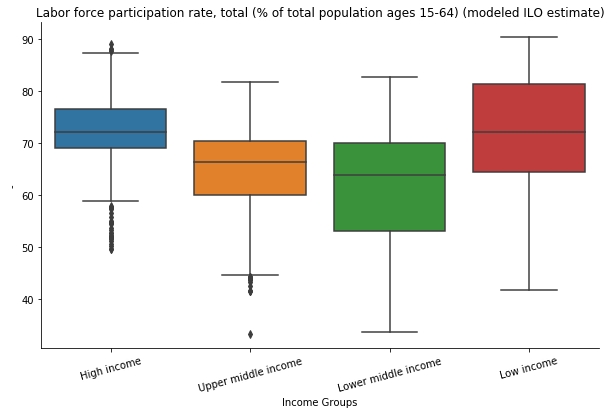


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            72.227803         64.691762         61.754849   70.930765


           Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper  reject
------------------------------------------------------------------------
    High income          Low income      -1.297  -2.8433   0.2492 False 
    High income     Lower middle income -10.473  -11.9294 -9.0165  True 
    High income     Upper middle income  -7.536  -9.0692  -6.0028  True 
     Low income     Lower middle income -9.1759  -10.7596 -7.5922  True 
     Low income     Upper middle income  -6.239  -7.8935  -4.5845  True 
Lower middle income Upper middle income  2.9369   1.366    4.5078  True 
------------------------------

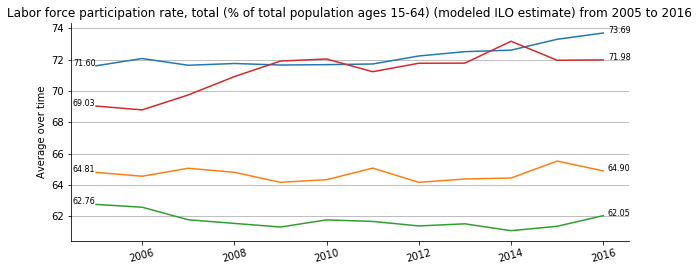

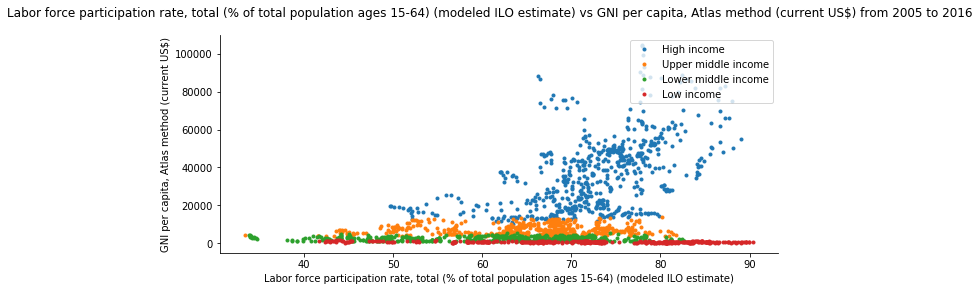

A deeper dive into each income group:


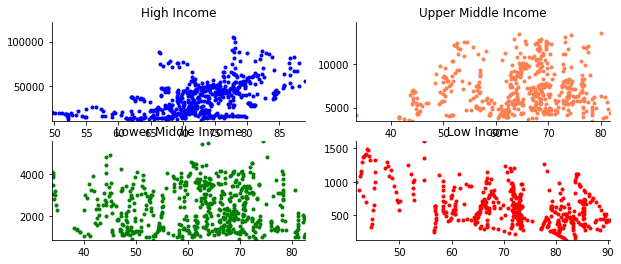

Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate) and GNI per capita, Atlas method (current US$) are correlated by:
0.2790 with a p-value of 1.3777582504194993e-44 among all income groups
0.4094 with a p-value of 3.7505893410501305e-33 among High income countries.
0.0847 with a p-value of 0.046226237657361904 among Upper middle income countries.
-0.0530 with a p-value of 0.1899762863770335 among Lower middle income countries.
-0.4226 with a p-value of 9.758175758523983e-22 among Low income countries.


In [24]:
view('Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)')

<a id='contributing family workers'></a>
#### Contributing family workers, total (% of total employment) 


1. Contributing family workers are those who work with family members who operate their own businesses.  High income countries have only 1% of their total workforce as contributing family workers, as opposed to 5% of upper middle income countries, 13.5% of lower middle income countries and 24.8% of low income countries.  This is likely due to the need to work as a community within a household in order to survive as income categories lessen.  For example, a family in a third world country may own and operate a small grocery store from within their house, or parents employing their children in a restaurant.


2. The difference in means significantly grow exponentially as countries fall into lower income groups.  The difference from high to upper middle income is 4.3%, upper middle to lower middle, 8%, lower middle to low, 11%, and high to low income, 23.7%.


3. While high income and low income countries have seen a very small decline in contributing family workers from 2005 to 2016, less than 0.5%, middle income countries have seen an increase in contributing family workers by roughly 2.5%.


4. While contributing family worker rates in each income group, individually, have little or very little negative correlation to GNI per capita, all income groups do have negative correlation with a pearson correlation score of -0.4186.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Social Protection and Labor'>Social Protection and Labor</a>

Indicator Definition: 

Contributing family workers are those workers who hold "self-employment jobs" as own-account workers in a market-oriented establishment operated by a related person living in the same household.


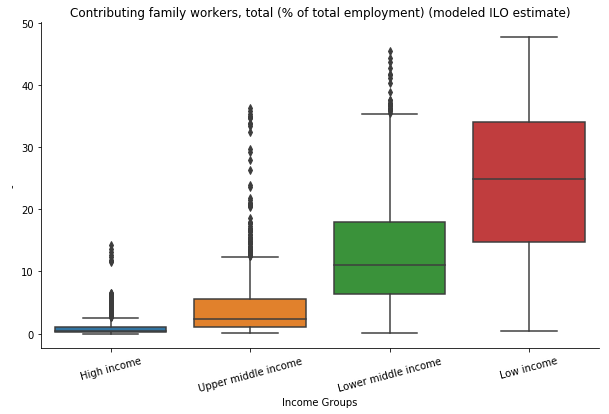


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             1.088657          5.382122         13.469821   24.818949


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     23.7303  22.4315  25.0291   True 
    High income     Lower middle income 12.3812  11.1578  13.6045   True 
    High income     Upper middle income  4.2935   3.0057   5.5813   True 
     Low income     Lower middle income -11.3491 -12.6793 -10.0189  True 
     Low income     Upper middle income -19.4368 -20.8265 -18.0471  True 
Lower middle income Upper middle income -8.0877  -9.4072  -6.7682   True 
---------------------

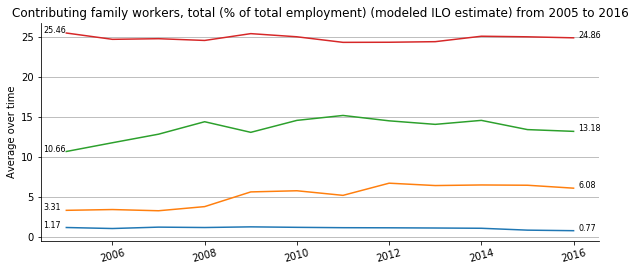

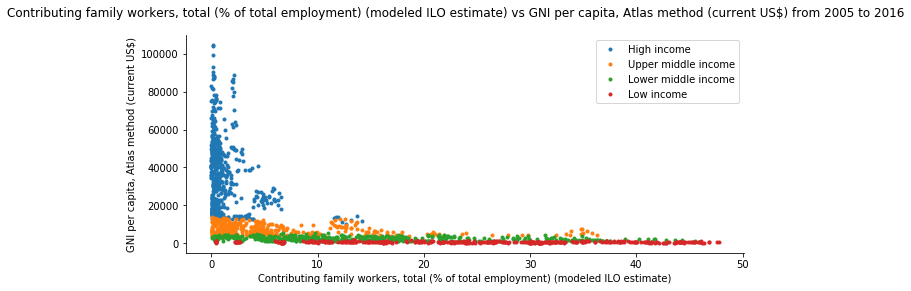

A deeper dive into each income group:


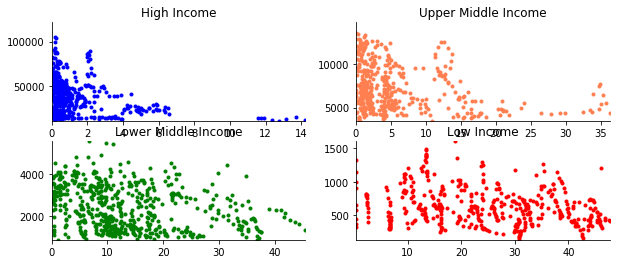

Contributing family workers, total (% of total employment) (modeled ILO estimate) and GNI per capita, Atlas method (current US$) are correlated by:
-0.4186 with a p-value of 1.8443636996644866e-103 among all income groups
-0.1983 with a p-value of 2.024811320903307e-08 among High income countries.
-0.2297 with a p-value of 4.42524236046424e-08 among Upper middle income countries.
-0.2677 with a p-value of 1.598517798748643e-11 among Lower middle income countries.
-0.2241 with a p-value of 9.436150876944829e-07 among Low income countries.


In [25]:
view('Contributing family workers, total (% of total employment) (modeled ILO estimate)')

<a id='dependents of the workforce'></a>
#### Age dependency ratio (% of working-age population) 


1. The ratio of dependents to the working population grows as income groups become lower.  High income countries have a dependency ratio of 46.5%, upper middle, 51.5%, lower middle, 64.7% and low, 83.9%.


2. There is a significant difference in means from income group to income group with high income countries having a dependency ratio 37.4% lower than low income countries.  This is likely due to the increased rate of fertility for women in lower income countries coupled with the possibility that people over 64 years of age are more likely to have retirement funds in higher income countries.


3. The dependency ratio remains roughly the same for all income groups from 2005 to 2016.


4. Dependency to the working population is negatively correlated to GNI per capita among all income groups with a pearson correlation score of -0.4156.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Social Protection and Labor'>Social Protection and Labor</a>

Indicator Definition: 

Age dependency ratio is the ratio of dependents--people younger than 15 or older than 64--to the working-age population--those ages 15-64. Data are shown as the proportion of dependents per 100 working-age population.


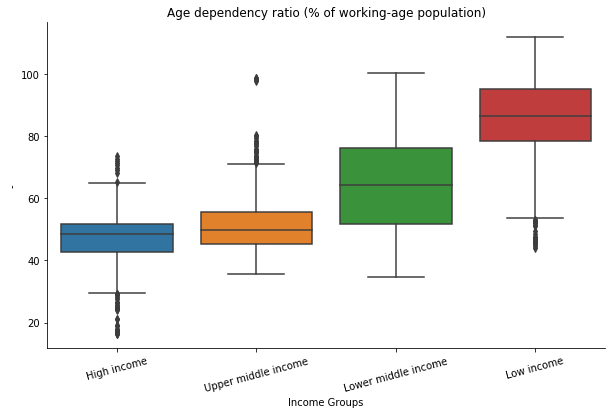


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            46.475034         51.491167         64.746417   83.852447


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     37.3774  35.4221  39.3327   True 
    High income     Lower middle income 18.2714  16.4569  20.0859   True 
    High income     Upper middle income  5.0161   3.1106   6.9217   True 
     Low income     Lower middle income -19.106  -21.1055 -17.1065  True 
     Low income     Upper middle income -32.3613 -34.4437 -30.2788  True 
Lower middle income Upper middle income -13.2553 -15.2061 -11.3044  True 
---------------------

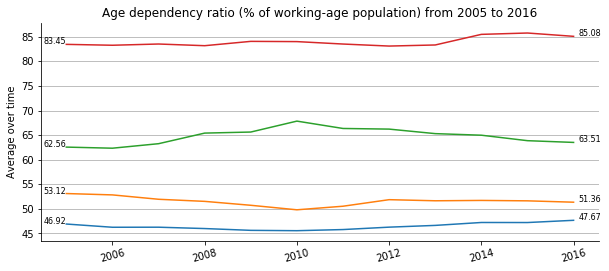

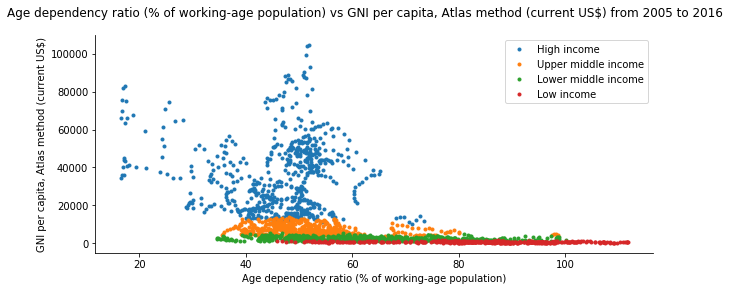

A deeper dive into each income group:


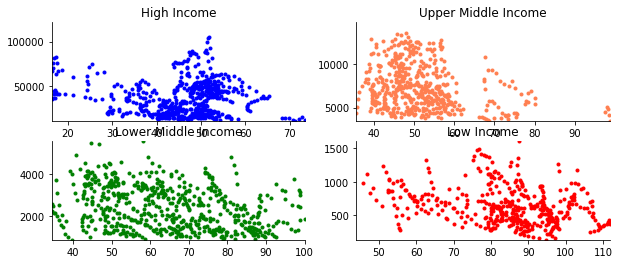

Age dependency ratio (% of working-age population) and GNI per capita, Atlas method (current US$) are correlated by:
-0.4156 with a p-value of 7.63601019431723e-102 among all income groups
-0.0327 with a p-value of 0.35896283262008366 among High income countries.
-0.2396 with a p-value of 1.0889396900304245e-08 among Upper middle income countries.
-0.3080 with a p-value of 6.221248584935253e-15 among Lower middle income countries.
-0.2767 with a p-value of 1.0951749075474393e-09 among Low income countries.


In [26]:
view('Age dependency ratio (% of working-age population)')

<a id='employment in agriculture'></a>
#### Employment in agriculture (% of total employment) 


1. Employment in agriculture is extremely low among high income countries with 4.5% of the total workforce in that sector.  It grows exponentially as countries fall into lower income groups.  Upper middle income countries have 17.8% of their workforce involved in agriculture, while lower middle income countries have 36.4% and low income countries at 60.9%.


2. The difference in means is significant from income group to income group and the range widens as well.  While over half of the total workforce in low income countries work in agriculture, not even 1 in 20 of the total workforce do in high income countries.  The difference in means is over 56%. 


3. From 2005 to 2016, every income group, except high income countries, have seen a small rise in the total work force in agriculture.


4. Employment in agriculture is negatively correlated to GNI per capita among all income groups with a pearson correlation score of -0.5310.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Social Protection and Labor'>Social Protection and Labor</a>

Indicator Definition: 

Employment is defined as persons of working age who were engaged in any activity to produce goods or provide services for pay or profit, whether at work during the reference period or not at work due to temporary absence from a job, or to working-time arrangement. The agriculture sector consists of activities in agriculture, hunting, forestry and fishing, in accordance with division 1 (ISIC 2) or categories A-B (ISIC 3) or category A (ISIC 4).


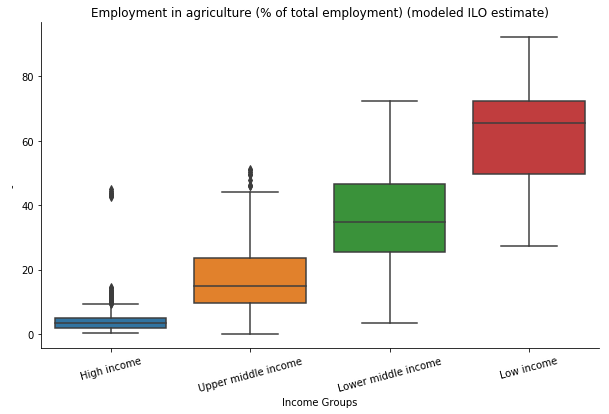


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean               4.4739         17.785273         36.433407   60.877198


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     56.4033  54.4984  58.3081   True 
    High income     Lower middle income 31.9595  30.1653  33.7537   True 
    High income     Upper middle income 13.3114  11.4226  15.2001   True 
     Low income     Lower middle income -24.4438 -26.3947 -22.4929  True 
     Low income     Upper middle income -43.0919 -45.1301 -41.0537  True 
Lower middle income Upper middle income -18.6481 -20.5833 -16.7129  True 
---------------------

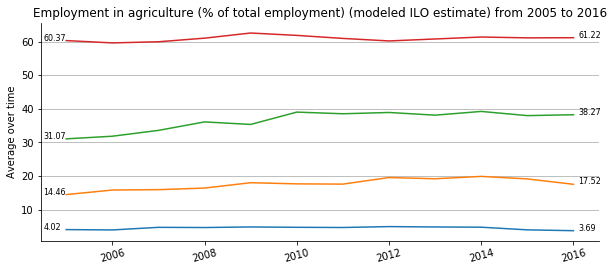

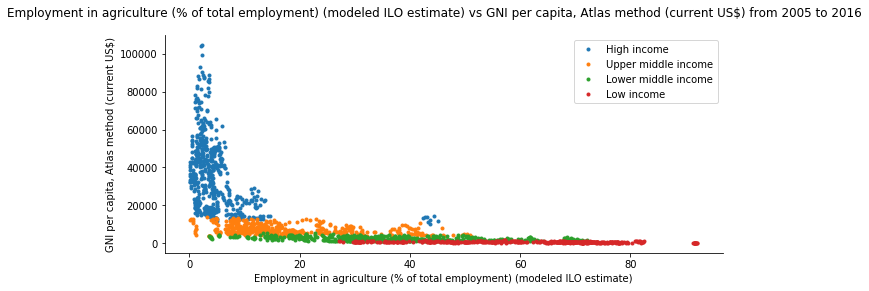

A deeper dive into each income group:


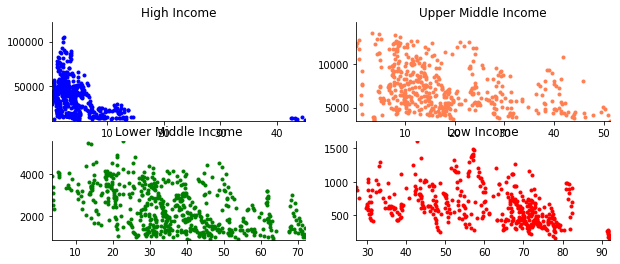

Employment in agriculture (% of total employment) (modeled ILO estimate) and GNI per capita, Atlas method (current US$) are correlated by:
-0.5310 with a p-value of 1.8303616628984274e-176 among all income groups
-0.2770 with a p-value of 2.5132860559047637e-15 among High income countries.
-0.3252 with a p-value of 3.848069588286838e-15 among Upper middle income countries.
-0.4475 with a p-value of 1.6243178862185153e-31 among Lower middle income countries.
-0.3939 with a p-value of 7.427354936357971e-19 among Low income countries.


In [27]:
view('Employment in agriculture (% of total employment) (modeled ILO estimate)')

<a id='employment in industry'></a>
#### Employment in industry (% of total employment) 


1. Employment in industry is roughly the same in high income and upper middle income countries ranging between 23% and 24% of the total workforce, although there are some outliers in high income countries that have up to 60% of the total workforce employed in industry.  It drops to 18.5% in lower middle income countries and 11% in low income countries.


2. The difference in means is significant from income group to income group with the exception of high income and upper middle income countries, which there is no significant difference.  High income countries have 1 in 4 workers in industry and average 12.6% more of their total workforce in industry than low income countries which have 1 in 10 workers.


3. From 2005 to 2016, all income groups have seen a drop, 1% to 3%, in employment in industry.  This is probably due to the increase of automation in manufacturing, quarrying, mining and some utility jobs.


4. As a whole, employment in industry has little correlation to GNI per capita.  High income countries have very little negative correlation, while the other income groups have little positive correlation.  The pearson correlation score is 0.2620.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Social Protection and Labor'>Social Protection and Labor</a>

Indicator Definition: 

Employment is defined as persons of working age who were engaged in any activity to produce goods or provide services for pay or profit, whether at work during the reference period or not at work due to temporary absence from a job, or to working-time arrangement. The industry sector consists of mining and quarrying, manufacturing, construction, and public utilities (electricity, gas, and water), in accordance with divisions 2-5 (ISIC 2) or categories C-F (ISIC 3) or categories B-F (ISIC 4).


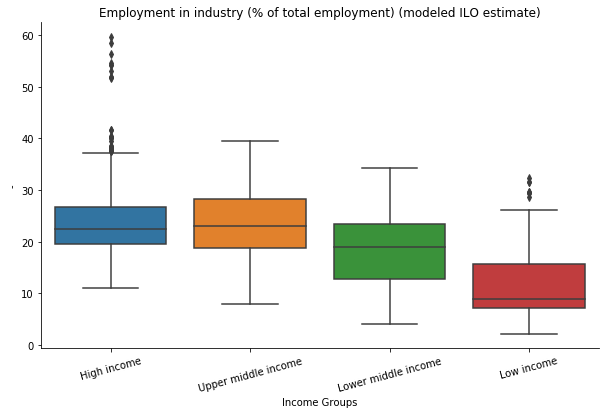


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            23.771686         23.138716         18.526192    11.09748


           Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper  reject
------------------------------------------------------------------------
    High income          Low income     -12.6742 -13.6965 -11.652  True 
    High income     Lower middle income -5.2455  -6.2084  -4.2826  True 
    High income     Upper middle income  -0.633  -1.6466   0.3806 False 
     Low income     Lower middle income  7.4287   6.3817   8.4757  True 
     Low income     Upper middle income 12.0412  10.9474  13.1351  True 
Lower middle income Upper middle income  4.6125   3.574    5.6511  True 
------------------------------

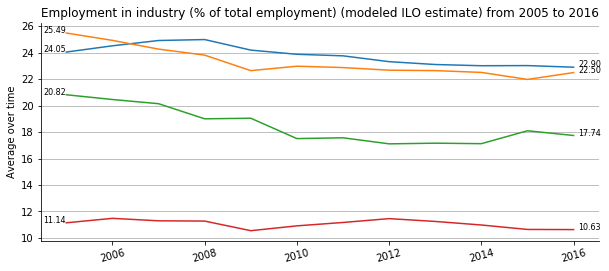

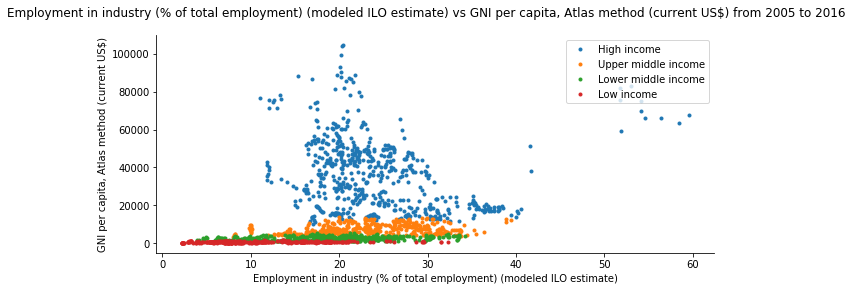

A deeper dive into each income group:


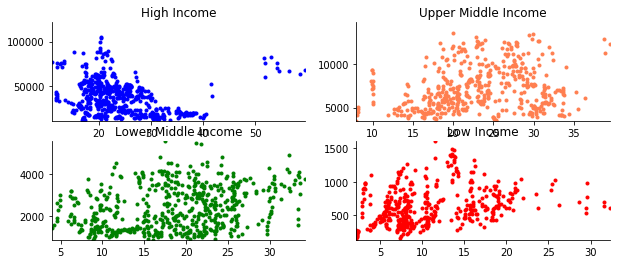

Employment in industry (% of total employment) (modeled ILO estimate) and GNI per capita, Atlas method (current US$) are correlated by:
0.2620 with a p-value of 2.4506348975825232e-39 among all income groups
-0.1582 with a p-value of 8.19917619498586e-06 among High income countries.
0.2039 with a p-value of 1.2752436418978108e-06 among Upper middle income countries.
0.2593 with a p-value of 7.11546165834026e-11 among Lower middle income countries.
0.2893 with a p-value of 1.7070520727787815e-10 among Low income countries.


In [28]:
view('Employment in industry (% of total employment) (modeled ILO estimate)')

<a id='employment in service'></a>
#### Employment in services (% of total employment) 


1. Employment in services is extremely high among high income countries with 71.8% of the total workforce in that sector.  It drops as income groups change with upper middle countries having 59% of their total workforce in service, lower middle countries with 45% and low income countries with 28%.


2. The difference in means is significant from income group to income group and ranges between 12% and 17% between groups.  High income countries have 7 in 10 people from their total workforce in industry, while low income countries have 3 in 10.  This is likely because high income countries engage in more service related jobs, while low income countries engage in more agriculture related jobs.


3. There is not much of a change over time.


4. Employment in service is positively correlated to GNI per capita among all income groups with a pearson correlation score of 0.5616.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Social Protection and Labor'>Social Protection and Labor</a>

Indicator Definition: 

Employment is defined as persons of working age who were engaged in any activity to produce goods or provide services for pay or profit, whether at work during the reference period or not at work due to temporary absence from a job, or to working-time arrangement. The services sector consists of wholesale and retail trade and restaurants and hotels; transport, storage, and communications; financing, insurance, real estate, and business services; and community, social, and personal services, in accordance with divisions 6-9 (ISIC 2) or categories G-Q (ISIC 3) or categories G-U (ISIC 4).


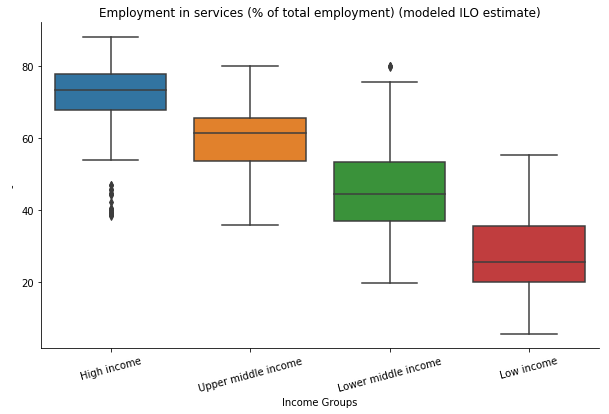


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            71.754455         59.076023         45.040416   28.025322


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -43.7291 -45.305  -42.1532  True 
    High income     Lower middle income -26.714  -28.1984 -25.2297  True 
    High income     Upper middle income -12.6784 -14.241  -11.1159  True 
     Low income     Lower middle income 17.0151  15.4011  18.6291   True 
     Low income     Upper middle income 31.0507  29.3645  32.7369   True 
Lower middle income Upper middle income 14.0356  12.4346  15.6366   True 
---------------------

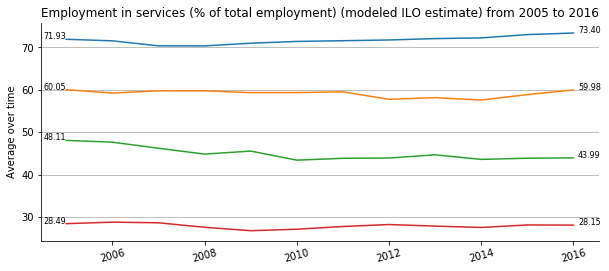

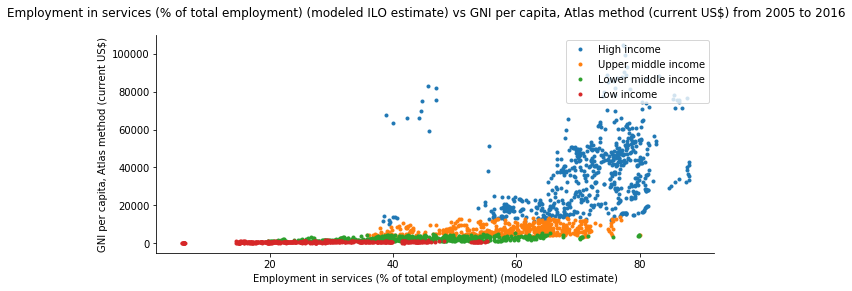

A deeper dive into each income group:


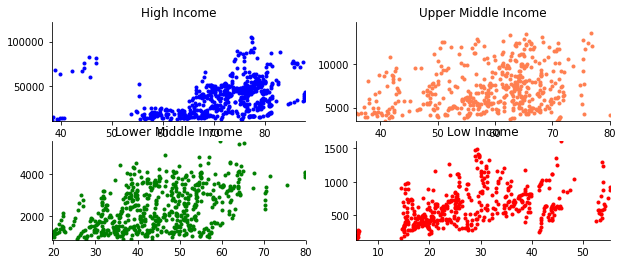

Employment in services (% of total employment) (modeled ILO estimate) and GNI per capita, Atlas method (current US$) are correlated by:
0.5616 with a p-value of 1.4561041133609443e-201 among all income groups
0.2939 with a p-value of 3.831439583744707e-17 among High income countries.
0.2472 with a p-value of 3.5988980790734346e-09 among Upper middle income countries.
0.4543 with a p-value of 1.529008743423558e-32 among Lower middle income countries.
0.3962 with a p-value of 4.487918995517324e-19 among Low income countries.


In [29]:
view('Employment in services (% of total employment) (modeled ILO estimate)')

<a id='Health'></a>
# Health 

____________

The indicators that pertained to health dealt with access to:
- ***basic drinking water***
- ***fertility rates***
- ***infant mortality rates***
- ***life expectancy***

Access to basic drinking water is major in determining income groups.  Almost 99% of high income countries have access as opposed to 59% of low income countries, a 40% difference in population access with the middle income countries ranging in between.  Access to basic needs, such as water, may lead to increased life expectancy and lower infant mortality rates.

The average fertility rate among income groups rises as countries fall into lower income categories.  High income mothers have roughly 2 children, while upper middle mothers range between 2 and 3, lower middle between 2 and 4, and low income mothers between 4 and 6 children.

Infant mortality exponentially grows as income levels decline among countries.  Low income countries have an infant mortality rate 9 times that of high income countries.  Although the rate is high, low income countries have seen a large decline in infant mortality rates from 2005 to 2016 dropping from 66 deaths per 1000 births to 51.

Although, on average, life expectancy is much higher among high income countries, the minimum life expectancy among most income groups is on the rise per year with low income countries leading the extension averaging a 3 year increase in life expectancy.

<a href='#Table of Contents'>Table of Contents</a>

_______________

<a id='basic drinking water'></a>
#### People using at least basic drinking water services (% of population) 


1. Access to basic drinking water is prevalent among higher income countries with an average of over 93% of the population having access.  Lower income countries' access drops to 82% and in the lowest income countries, access to basic drinking water sharply declines to 59%.


2. The difference in means is significant from income group to income group with 39% more of the population in high income countries having access to basic drinking water than low income countries.


3. There is no significant change over time in access other than lower middle income countries, which dropped from 85% to 80% from 2005 to 2016.


4. Access to basic drinking water is also positively correlated to GNI per capita among all income groups with a pearson correlation score of 0.4328.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Health'>Health</a>

Indicator Definition: 

The percentage of people using at least basic water services.  This indicator encompasses both people using basic water services as well as those using safely managed water services.  Basic drinking water services is defined as drinking water from an improved source, provided collection time is not more than 30 minutes for a round trip.  Improved water sources include piped water, boreholes or tubewells, protected dug wells, protected springs, and packaged or delivered water.


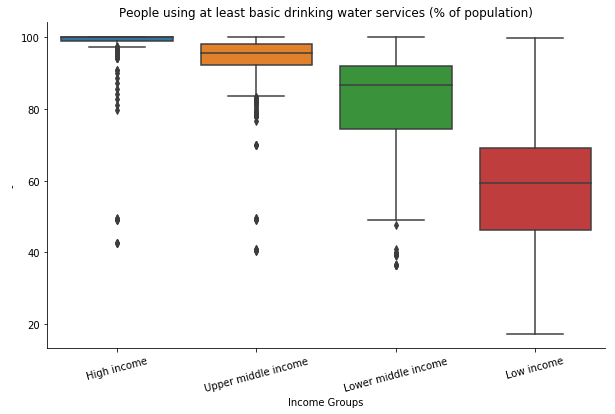


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            98.298006         93.090884         82.290125   59.238927


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -39.0591 -40.8397 -37.2785  True 
    High income     Lower middle income -16.0079 -17.6522 -14.3635  True 
    High income     Upper middle income -5.2071  -6.8991  -3.5152   True 
     Low income     Lower middle income 23.0512  21.1786  24.9238   True 
     Low income     Upper middle income  33.852  31.9374  35.7665   True 
Lower middle income Upper middle income 10.8008   9.0122  12.5893   True 
---------------------

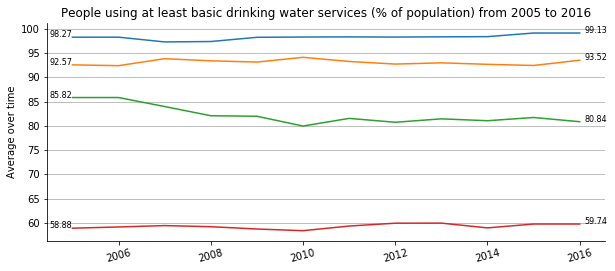

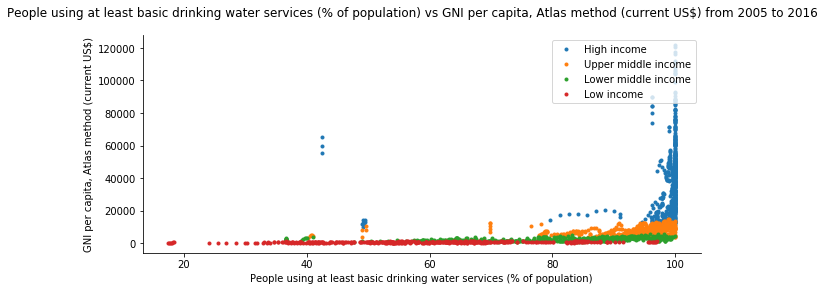

A deeper dive into each income group:


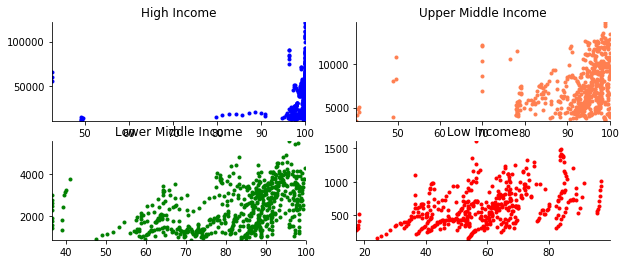

People using at least basic drinking water services (% of population) and GNI per capita, Atlas method (current US$) are correlated by:
0.4328 with a p-value of 3.065175190201998e-111 among all income groups
0.1312 with a p-value of 0.00022434173029832767 among High income countries.
0.2490 with a p-value of 2.742440969687793e-09 among Upper middle income countries.
0.4178 with a p-value of 2.703806094827619e-27 among Lower middle income countries.
0.3889 with a p-value of 2.2141782351059444e-18 among Low income countries.


In [30]:
view('People using at least basic drinking water services (% of population)') #-#

<a id='fertility rates'></a>
#### Fertility rate, total (births per woman) 


1. The average fertility rate among income groups rises as countries fall into lower income categories.  High income mothers have roughly 2 children, while upper middle mothers range between 2 and 3, lower middle between 2 and 4, and low income mothers between 4 and 6 children.


2. The difference in means is significant from income group to income group.


3. From 2005 to 2016, fertility rates have slightly dropped for low income and high income countries, while it has slightly risen for the middle income countries.


4. Fertility rate is negatively correlated to GNI per capita among all income groups with a pearson correlation score of -0.4438.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Health'>Health</a>

Indicator Definition: 

Total fertility rate represents the number of children that would be born to a woman if she were to live to the end of her childbearing years and bear children in accordance with age-specific fertility rates of the specified year.


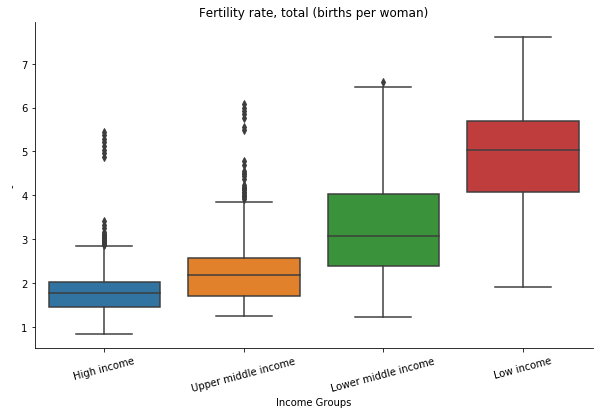


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean             1.803291          2.267659          3.241761    4.828446


           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
       group1              group2       meandiff  lower   upper  reject
-----------------------------------------------------------------------
    High income          Low income      3.0252   2.8743  3.176   True 
    High income     Lower middle income  1.4385   1.2986  1.5784  True 
    High income     Upper middle income  0.4644   0.3172  0.6115  True 
     Low income     Lower middle income -1.5867  -1.7426 -1.4307  True 
     Low income     Upper middle income -2.5608  -2.7232 -2.3983  True 
Lower middle income Upper middle income -0.9741  -1.1265 -0.8217  True 
---------------------------------------

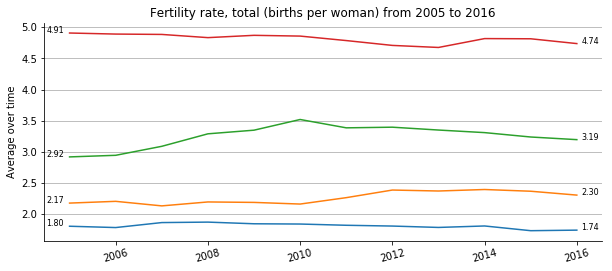

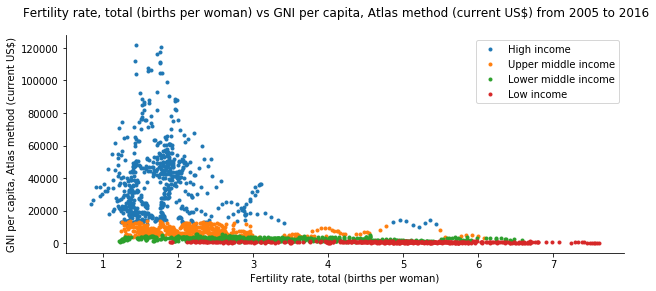

A deeper dive into each income group:


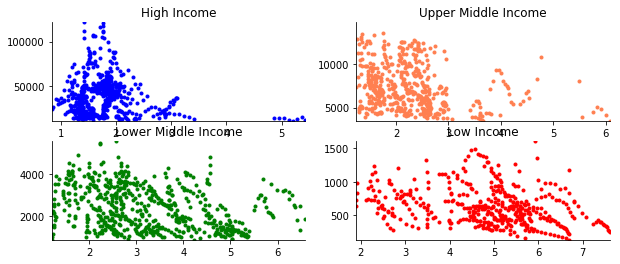

Fertility rate, total (births per woman) and GNI per capita, Atlas method (current US$) are correlated by:
-0.4438 with a p-value of 1.607314591730561e-117 among all income groups
-0.1118 with a p-value of 0.0016819825443649288 among High income countries.
-0.2426 with a p-value of 7.038134244448032e-09 among Upper middle income countries.
-0.2959 with a p-value of 7.476960537977086e-14 among Lower middle income countries.
-0.2678 with a p-value of 3.812241150867498e-09 among Low income countries.


In [31]:
view('Fertility rate, total (births per woman)')

<a id='infant mortality rates'></a>
#### Mortality rate, infant (per 1,000 live births) 


1. Infant mortality rate rises almost exponentially as income groups change.  The average mortality rate for high income countries is 6.3 deaths per 1000 births, and rises to 17 for upper middle income, 32 for lower middle income, and 59 for low income countries.  This is likely due to the difference in access to basic needs and quality of life among the groups.


2. The difference in means is significant from income group to income group with low income countries having a mortality rate roughly 9 times that of high income countries.


3. Although mortality rate is high among low income countries, mortality rates have consistently dropped yearly from 2005 to 2016 from an average of 66.10 deaths per 1000 births to 51.24.


4. Infant mortality rate is also negatively correlated to GNI per capita among all income groups with a pearson correlation score of -0.4480.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Health'>Health</a>

Indicator Definition: 

Infant mortality rate is the number of infants dying before reaching one year of age, per 1,000 live births in a given year.


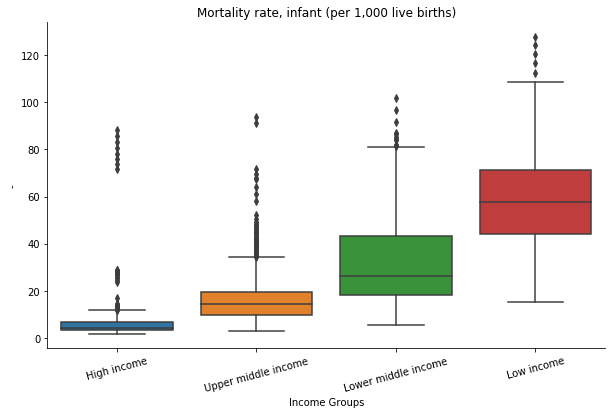


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean              6.30624         17.271165         32.336868   59.195949


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     52.8897  50.3993  55.3801   True 
    High income     Lower middle income 26.0306  23.7114  28.3499   True 
    High income     Upper middle income 10.9649    8.57   13.3598   True 
     Low income     Lower middle income -26.8591 -29.3459 -24.3722  True 
     Low income     Upper middle income -41.9248 -44.4823 -39.3672  True 
Lower middle income Upper middle income -15.0657 -17.4569 -12.6745  True 
---------------------

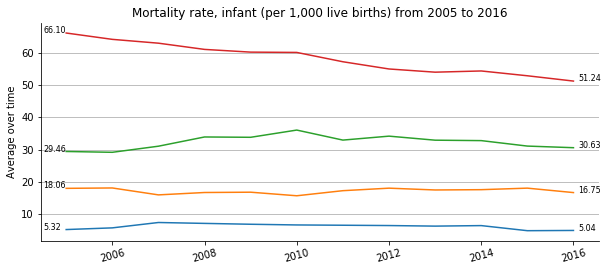

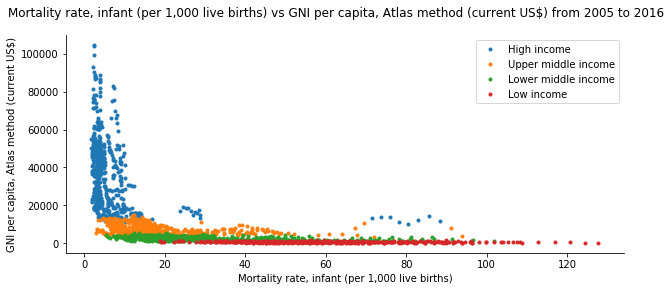

A deeper dive into each income group:


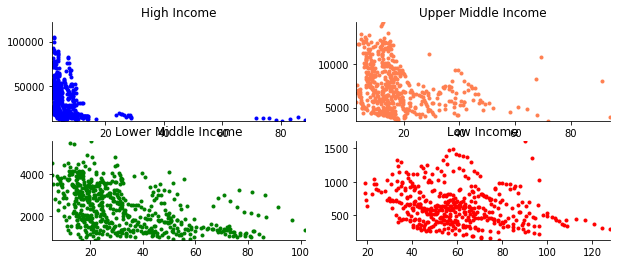

Mortality rate, infant (per 1,000 live births) and GNI per capita, Atlas method (current US$) are correlated by:
-0.4480 with a p-value of 5.720807334258687e-120 among all income groups
-0.2335 with a p-value of 3.30229717510767e-11 among High income countries.
-0.2796 with a p-value of 1.9793280803402602e-11 among Upper middle income countries.
-0.4639 with a p-value of 4.934217678909909e-34 among Lower middle income countries.
-0.2431 with a p-value of 9.78238885565624e-08 among Low income countries.


In [32]:
view('Mortality rate, infant (per 1,000 live births)')

 <a id='life expectancy'></a>
 #### Life expectancy at birth, total (years)


1. Average life expectancy differs by about 5 to 6 years between each income group with high income countries averaging 78 years and low income countries averaging 61.  As income groups head towards lower income countries, the range in life expectancy also widens.


2. The difference in means is significant from income group to income group.


3. From 2005 to 2016, life expectancy as seen a greater increase in low income countries, 3 years, than it has in the middle and higher income countries, 1 to 2 years.


4. Life expectancy is positively correlated to GNI per capita among all income groups with a pearson correlation score of 0.5774.  Although it's correlation is a much lower, 0.2047, with upper middle income countries which only seen an increase of life expectancy of 1 year from 2005 to 2016.

<a href='#Table of Contents'>Table of Contents</a>

<a href='#Health'>Health</a>

Indicator Definition: 

Life expectancy at birth indicates the number of years a newborn infant would live if prevailing patterns of mortality at the time of its birth were to stay the same throughout its life.


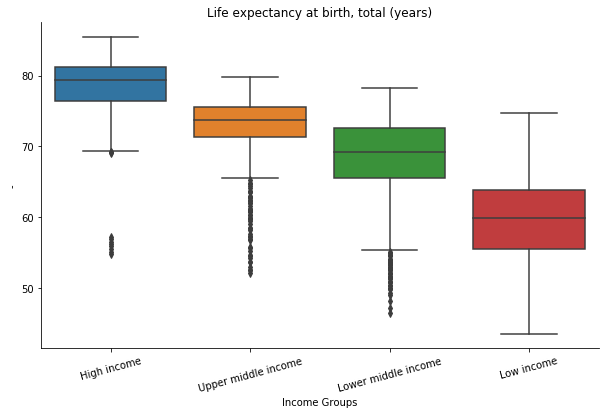


    Null Hypothesis: There is no difference in means between income groups
    Alternative Hypothesis: There is a difference in means betweeen income groups
    
income_group  High income  Upper mid income  Lower mid income  Low income
mean            78.500092         72.440819         68.053391   59.707234


            Multiple Comparison of Means - Tukey HSD,FWER=0.05           
       group1              group2       meandiff  lower    upper   reject
-------------------------------------------------------------------------
    High income          Low income     -18.7929 -19.6086 -17.9771  True 
    High income     Lower middle income -10.4467 -11.2048 -9.6886   True 
    High income     Upper middle income -6.0593  -6.8559  -5.2626   True 
     Low income     Lower middle income  8.3462   7.5028   9.1895   True 
     Low income     Upper middle income 12.7336  11.8555  13.6117   True 
Lower middle income Upper middle income  4.3874   3.5625   5.2123   True 
---------------------

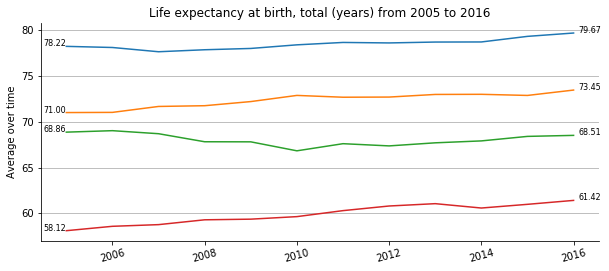

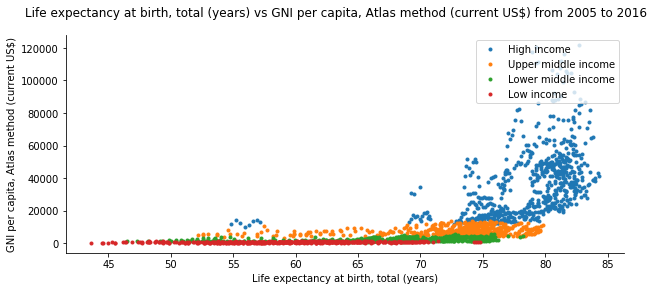

A deeper dive into each income group:


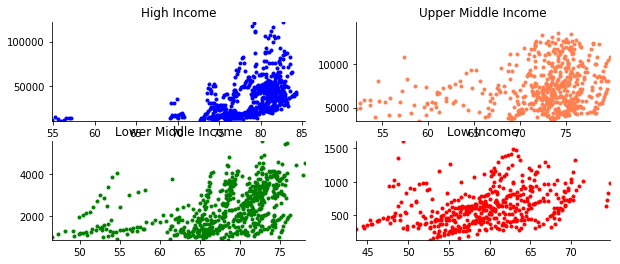

Life expectancy at birth, total (years) and GNI per capita, Atlas method (current US$) are correlated by:
0.5774 with a p-value of 1.5819579197548615e-215 among all income groups
0.4196 with a p-value of 6.598710435528524e-35 among High income countries.
0.2047 with a p-value of 1.1621395840757384e-06 among Upper middle income countries.
0.4434 with a p-value of 6.551592441766118e-31 among Lower middle income countries.
0.3264 with a p-value of 4.1747724621905853e-13 among Low income countries.


In [33]:
view('Life expectancy at birth, total (years)')

<a id='Diving Deeper with Indicator Correlations'></a>
## Diving Deeper with Indicator Correlations 


Many of the features have positive and negative correlation with each other.  In a more complex project, it would be great to see which ones do and don't and find the reasons why.  Because this is a classification project, the main concern pertains to GNI per capita and it's relation to the feaures.

<a href='#Table of Contents'>Table of Contents</a>

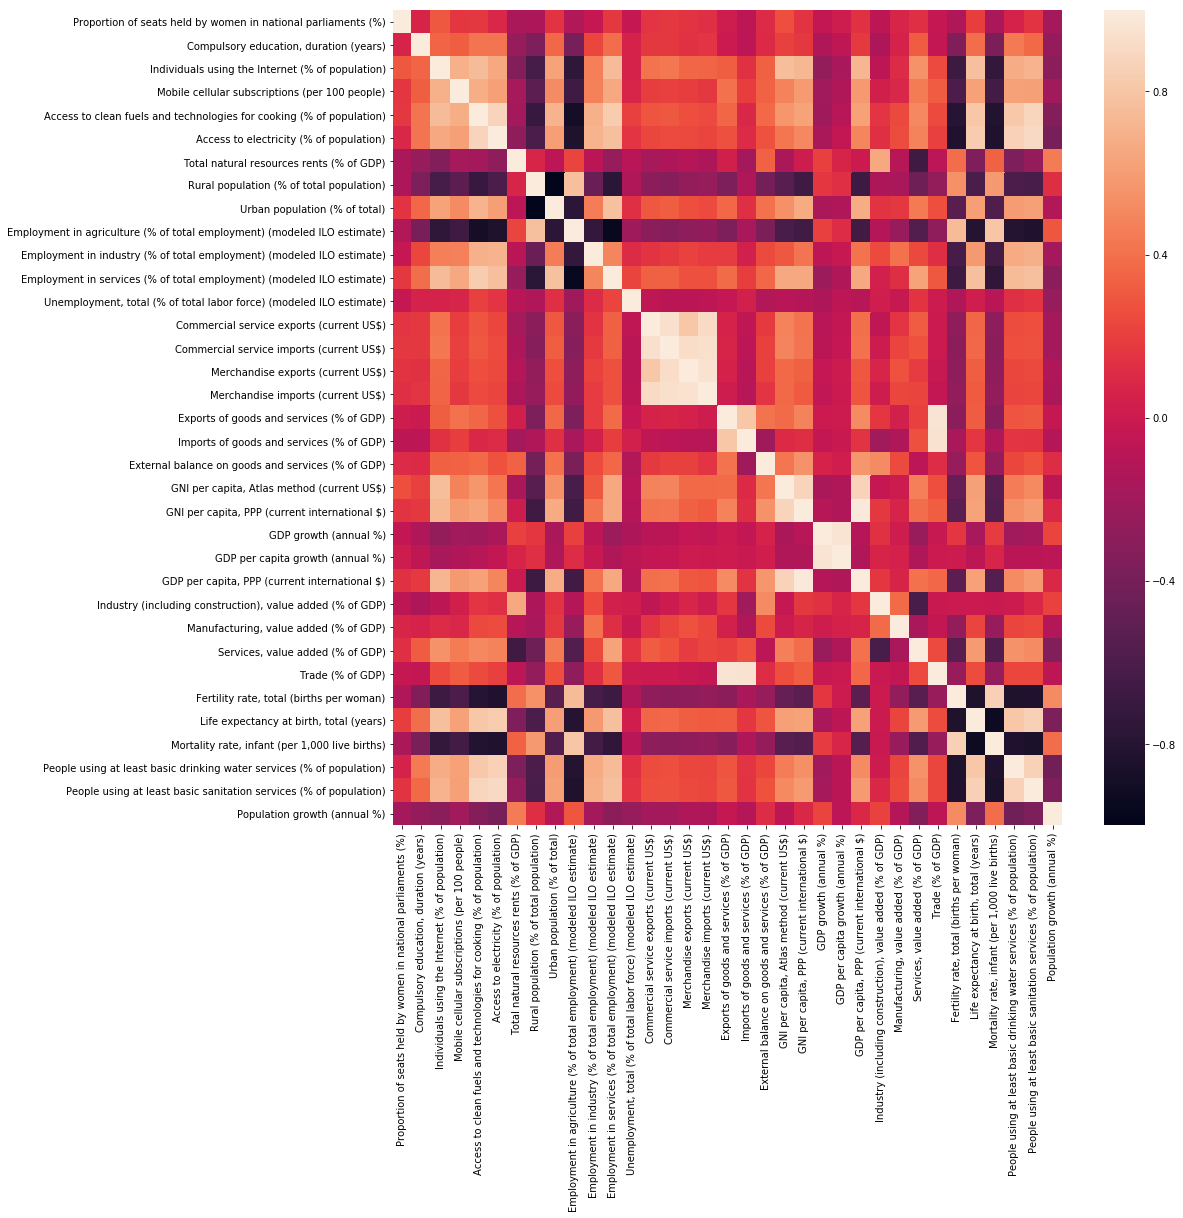

In [34]:
plt.figure(figsize=(15,15))
correlations = wdi_corr.corr()
sns.heatmap(correlations,
           xticklabels=correlations.columns.values,
           yticklabels=correlations.columns.values)
plt.show()

<a id='End'></a>
## Conclusion 

In conclusion, we have found that:
- Countries change income groups from year to year
- Higher income groups are growing while lower income groups are shrinking.
- Features are showing a growth in access and standards of living among all income groups.
- This all leads to the world becoming more developed.


The major indicator that determines income group is GNI per capita.  Countries fall into certain groups based off of this indicator.  This indicator is also correlated to many world development indicators and is worth a deep dive.

In analyzing our data, we were able to separate our indicators into various categories:
- Economic Policy and Debt
- Education and Gender Issues
- Access to Advanced Communications
- Environment, Resources and Population
- Social Protection and Labor
- Health

As we analyzed these indicators, we have seen many patterns as they relate to income groups.  We will now use what we have found to begin creating a machine learning model.

<a href='#Table of Contents'>Table of Contents</a>

In [35]:
# Save new df
# numbers.to_csv('WDI_csv/eda/numbers.csv')
# percents.to_csv('WDI_csv/eda/percents.csv')
# wdi_pivot.to_csv('WDI_csv/eda/wdi_pivot.csv')
# wdi.to_csv('WDI_csv/eda/wdi.csv')
# high.to_csv('WDI_csv/eda/high.csv')
# upper_middle.to_csv('WDI_csv/eda/upper_middle.csv')
# lower_middle.to_csv('WDI_csv/eda/lower_middle.csv')
# low.to_csv('WDI_csv/eda/low.csv')
# income_group_criteria.to_csv('WDI_csv/eda/income_group_criteria.csv')
# gni_stats.to_csv('WDI_csv/eda/gni_stats.csv')